In [1]:
import os
import random

import dateutil.relativedelta as relativedelta

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web

from scipy import stats
from scipy.cluster import hierarchy

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from typing import Any, List, Optional, Union, Tuple

In [2]:
# set N used in n-largest or smallest
N = 10

In [3]:
# set style
plt.style.use("seaborn-notebook")

# set ratio of figure
ratio = (16, 9)


In [4]:
# set fixed seed
def seed_everything(seed) -> None:
    """
    Seeds basic parameters for reproducibility of results.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    # pandas and numpy as discussed here: https://stackoverflow.com/a/52375474/5755604
    np.random.seed(seed)


seed = 42
seed_everything(seed)


This notebook performs an eda on the training set only to avoid data leakage. ⚠️

In [5]:
data = pd.read_parquet(
    "gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_extended_60.parquet"
).sample(frac=0.1, axis=0, random_state=seed)


/home/kit/stud/uloak/.local/lib/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


## Notes on data set 🗃️

**Overview on ticker symbols:**
- `others` identified by issue type.
- 5th letter has a special meaning as found in [this table](https://en.wikipedia.org/wiki/Ticker_symbol):

| Letter                  | Letter contd.              | Letter contd.                                    |
|--------------------------------|-------------------------------------|------------------------------------------------|
| A – Class "A"                  | K – Nonvoting (common)              | U – Units                                      |
| B – Class "B"                  | L – Miscellaneous                   | V – Pending issue and distribution             |
| C – NextShares                 | M – fourth class – preferred shares | W – Warrants                                   |
| D – New issue or reverse split | N – third class – preferred shares  | X – Mutual fund                                |
| E – Delinquent SEC filings     | O – second class – preferred shares | Y – American depositary receipt (ADR)          |
| F – Foreign                    | P – first class preferred shares    | Z – Miscellaneous situations                   |
| G – first convertible bond     | Q – In bankruptcy                   | Special codes                                  |
| H – second convertible bond    | R – Rights                          | PK – A Pink Sheet, indicating over-the-counter |
| I – third convertible bond     | S – Shares of beneficial interest   | SC – Nasdaq Small Cap                          |
| J – Voting share – special     | T – With warrants or rights         | NM – Nasdaq National Market                    |


**Coverage:**

*	Options on U.S. listed Stock, ETFs, and Indices disseminated over the Options Price Reporting Authority (OPRA) market data feed 
*	Global Trading Hours (GTH) trades are included if between 03:00am-09:15am U.S. Eastern, and for the 16:15pm 17:00pm Curb session.  GTH trades outside of these time ranges will *not* be included. 

Found [here.](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf)

**Exchange Identifier:**

- 5 = Chicago Board Options Exchange (CBOE)
- 6 = International Securities Exchange (ISE)

Found [here.](https://datashop.cboe.com/documents/livevol_exchange_ids.csv)


**Issue Types:**

Issue Type = the type of security: 
- 0 = Common Stock 
- A = Market index 
- 7 = Mutual or investment trust fund 
- F = ADR/ADS 
- % = Exchange-traded fund 
- (blank) = Unspecified

Received from supervisor.

Adapted from the cboe data shop found at [option trades](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf) and [option quotes](https://datashop.cboe.com/documents/Option_Quotes_Layout.pdf).

|     Column Label                                                          |     Data   Type     |     Description                                                                                                                                                                                                         |
|---------------------------------------------------------------------------|---------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     underlying_symbol                                                     |     string          |     The underlying stock or index.  An index will utilize a caret (^) prefix,   i.e. ^NDX,^SPX,^VIX…etc.  Underlyings   with classes may utilize a dot (.) instead of a slash or space, i.e. BRK.B,   RDS.A, RDS.B.     |
|     quote_datetime                                                        |     datetime        |     The trading date and timestamp of the trade in   U.S. Eastern time. Ex:  yyyymm-dd   hh:mm:ss.000                                                                                                                   |
|     sequence_number                                                       |     integer         |     Trade Sequence Number for the execution reported   by OPRA                                                                                                                                                          |
|     root                                                                  |     string          |     The option trading class symbol.  Non-standard roots may end with a digit                                                                                                                                           |
|     expiration                                                            |     date            |     The explicit expiration date of the option:   yyyy-mm-dd                                                                                                                                                            |
|     strike                                                                |     numeric         |     The exercise/strike price of the option                                                                                                                                                                             |
|     option_type                                                           |     string          |     C for Call options, P for Put options                                                                                                                                                                               |
|     exchange_id                                                           |     integer         |     An identifier for the options exchange the trade   was executed on.  For a mapping, please   see Exchange ID   Mappings                                                                                             |
|     trade_size                                                            |     integer         |     The trade quantity                                                                                                                                                                                                  |
|     trade_price                                                           |     numeric         |     The trade price                                                                                                                                                                                                     |
|     trade_condition_id                                                    |     integer         |     The trade or sale condition of the execution.  For a mapping, please see Trade   Condition ID Mapping                                                                                                               |
|     canceled_trade_condition_id                                           |     integer         |     This field is no longer supported and will default   to 0 (zero).  See IDs 40-43 in the   Trade Condition ID Mapping file above                                                                                     |
|     best_bid                                                              |     numeric         |     The best bid price (NBB) at the time of the trade                                                                                                                                                                   |
|     best_ask                                                              |     numeric         |     The best ask/offer price (NBO) at the time of the   trade                                                                                                                                                           |
|     bid_size              |     integer         |     The largest size from an options exchange   participant on the best bid price (NBB)                                                                                                                                   |
|     bid                   |     numeric         |     The best bid price (NBB) at the interval time   stamp                                                                                                                                                                 |
|     ask_size              |     integer         |     The largest size from an options exchange   participant on the best offer price (NBO)                                                                                                                                 |
|     ask                   |     numeric         |     The best offer price (NBO) at the interval time   stamp                                                                                                                                                               |

## Dtypes, distributions, and memory consumption 🔭

In [6]:
data.head()


,QUOTE_DATETIME,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,...,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,issue_type,myn,buy_sell
3249281,2006-09-06 15:15:23,YNU,2008-01-19,5.0,C,5,2.05,1.95,2.05,2.05,...,186.0,1.90,2.20,26165240.0,5.0,2.20,2.20,0,1.225000,1
11026460,2009-01-30 14:21:48,UFB,2009-05-16,22.5,P,5,5.30,5.20,5.30,5.30,...,5.0,5.10,4.90,46287840.0,5.0,4.90,4.00,0,1.119125,-1
11754654,2009-04-06 13:43:46,UZK,2009-04-18,55.0,C,1,0.20,0.10,0.20,0.20,...,307.0,0.15,0.15,45632176.0,1.0,0.12,0.07,0,0.837000,1
12792033,2009-07-07 09:46:26,ASJ,2009-09-19,16.0,C,1,3.00,2.95,3.00,3.00,...,10.0,2.70,2.65,46669576.0,10.0,2.70,3.90,0,1.068437,-1
27061954,2013-04-09 11:29:28,GG,2013-04-20,36.0,P,1,3.71,3.65,3.75,3.75,...,21.0,3.65,4.80,83130448.0,2.0,3.65,2.81,0,1.111969,1


In [7]:
data.describe()


,STRK_PRC,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,myn,buy_sell
count,2.951032e+06,2.951032e+06,2.951032e+06,2.951032e+06,2.951032e+06,2.917282e+06,2.917282e+06,2.917282e+06,2.917282e+06,2.863609e+06,2.897181e+06,2948341.0,2.951032e+06,2.740702e+06,2.779600e+06,2.945975e+06,2.951032e+06
mean,7.595303e+01,1.460281e+01,4.992070e+00,4.894021e+00,5.252241e+00,5.110988e+00,4.898716e+00,3.515543e+02,3.608992e+02,5.035118e+00,4.983459e+00,50335740.0,6.725793e+01,5.023964e+00,4.988567e+00,1.018480e+01,-5.885060e-02
std,1.879976e+02,7.494708e+01,1.413471e+01,1.403218e+01,1.753075e+02,1.429339e+01,1.406812e+01,1.421814e+03,1.491231e+03,1.569917e+01,1.392152e+01,22274910.0,3.436836e+02,1.410720e+01,1.383299e+01,2.123719e+03,9.982670e-01
min,5.000000e-01,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02,1.000000e-02,21058526.0,1.000000e+00,1.000000e-02,1.000000e-02,6.478759e-07,-1.000000e+00
25%,2.250000e+01,2.000000e+00,5.500000e-01,5.000000e-01,6.000000e-01,6.000000e-01,5.000000e-01,2.200000e+01,2.500000e+01,5.900000e-01,5.800000e-01,32812544.0,4.000000e+00,6.000000e-01,6.100000e-01,8.639309e-01,-1.000000e+00
50%,4.000000e+01,5.000000e+00,1.750000e+00,1.700000e+00,1.800000e+00,1.850000e+00,1.700000e+00,7.300000e+01,7.800000e+01,1.800000e+00,1.790000e+00,45686300.0,1.000000e+01,1.800000e+00,1.800000e+00,9.606148e-01,-1.000000e+00
75%,6.600000e+01,1.000000e+01,4.650000e+00,4.500000e+00,4.750000e+00,4.800000e+00,4.500000e+00,2.610000e+02,2.690000e+02,4.700000e+00,4.650000e+00,62513352.0,3.800000e+01,4.680000e+00,4.670000e+00,1.056000e+00,1.000000e+00
max,7.900000e+03,4.000000e+04,1.266430e+03,1.264300e+03,2.000010e+05,1.270200e+03,1.264200e+03,9.999900e+04,9.999900e+04,9.999050e+03,1.275000e+03,127871976.0,4.400000e+04,1.285100e+03,1.260680e+03,1.789571e+06,1.000000e+00


In [8]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2951032 entries, 3249281 to 3360776
Data columns (total 22 columns):
 #   Column          Dtype         
---  ------          -----         
 0   QUOTE_DATETIME  datetime64[ns]
 1   ROOT            object        
 2   EXPIRATION      datetime64[ns]
 3   STRK_PRC        float32       
 4   OPTION_TYPE     category      
 5   TRADE_SIZE      int64         
 6   TRADE_PRICE     float32       
 7   BEST_BID        float32       
 8   BEST_ASK        float32       
 9   ask_ex          float32       
 10  bid_ex          float32       
 11  bid_size_ex     float32       
 12  ask_size_ex     float32       
 13  price_all_lead  float32       
 14  price_all_lag   float32       
 15  optionid        float32       
 16  day_vol         float32       
 17  price_ex_lead   float32       
 18  price_ex_lag    float32       
 19  issue_type      object        
 20  myn             float32       
 21  buy_sell        int8          
dtypes: category(

In [9]:
print(data.shape)


(2951032, 22)


In [10]:
print(data.shape)
# drop identical rows, if present
data.drop_duplicates(inplace=True)
print(data.shape)


(2951032, 22)
(2946810, 22)


**Observation:**
- Shape matches the shape reported in table 1 (panel A) of Grauer et al. paper.
- No duplicates

In [11]:
data.nunique()


QUOTE_DATETIME    2740379
ROOT                 8667
EXPIRATION            286
STRK_PRC             1570
OPTION_TYPE             2
TRADE_SIZE           1602
TRADE_PRICE         15887
BEST_BID             7618
BEST_ASK             7694
ask_ex               7667
bid_ex               7592
bid_size_ex         14751
ask_size_ex         15177
price_all_lead      14457
price_all_lag       14392
optionid           793238
day_vol              3573
price_ex_lead       15386
price_ex_lag        15188
issue_type              5
myn                637012
buy_sell                2
dtype: int64

In [12]:
data.head().T


,3249281,11026460,11754654,12792033,27061954
QUOTE_DATETIME,2006-09-06 15:15:23,2009-01-30 14:21:48,2009-04-06 13:43:46,2009-07-07 09:46:26,2013-04-09 11:29:28
ROOT,YNU,UFB,UZK,ASJ,GG
EXPIRATION,2008-01-19 00:00:00,2009-05-16 00:00:00,2009-04-18 00:00:00,2009-09-19 00:00:00,2013-04-20 00:00:00
STRK_PRC,5.0,22.5,55.0,16.0,36.0
OPTION_TYPE,C,P,C,C,P
TRADE_SIZE,5,5,1,1,1
TRADE_PRICE,2.05,5.3,0.2,3.0,3.71
BEST_BID,1.95,5.2,0.1,2.95,3.65
BEST_ASK,2.05,5.3,0.2,3.0,3.75
ask_ex,2.05,5.3,0.2,3.0,3.75


## Basic features🧸

Analysis of numerical features without any feature engineering.

### Correlations 🎲

<AxesSubplot:>

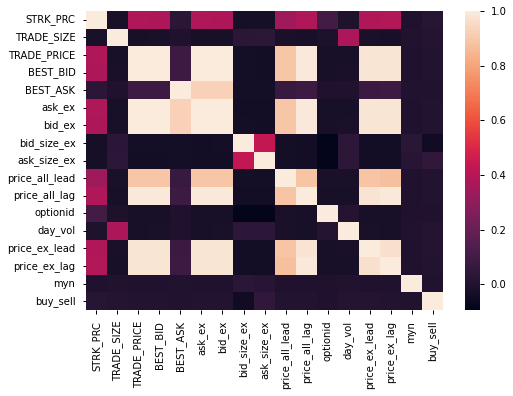

In [13]:
corr: pd.DataFrame = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)  # type: ignore


**Observation:**
* There are many highly correlated columns. The correlations are intuitive e. g., between `price_all_lead` and `price_ex_lead`.
* Few columns show a weak correlation with target (see also below).

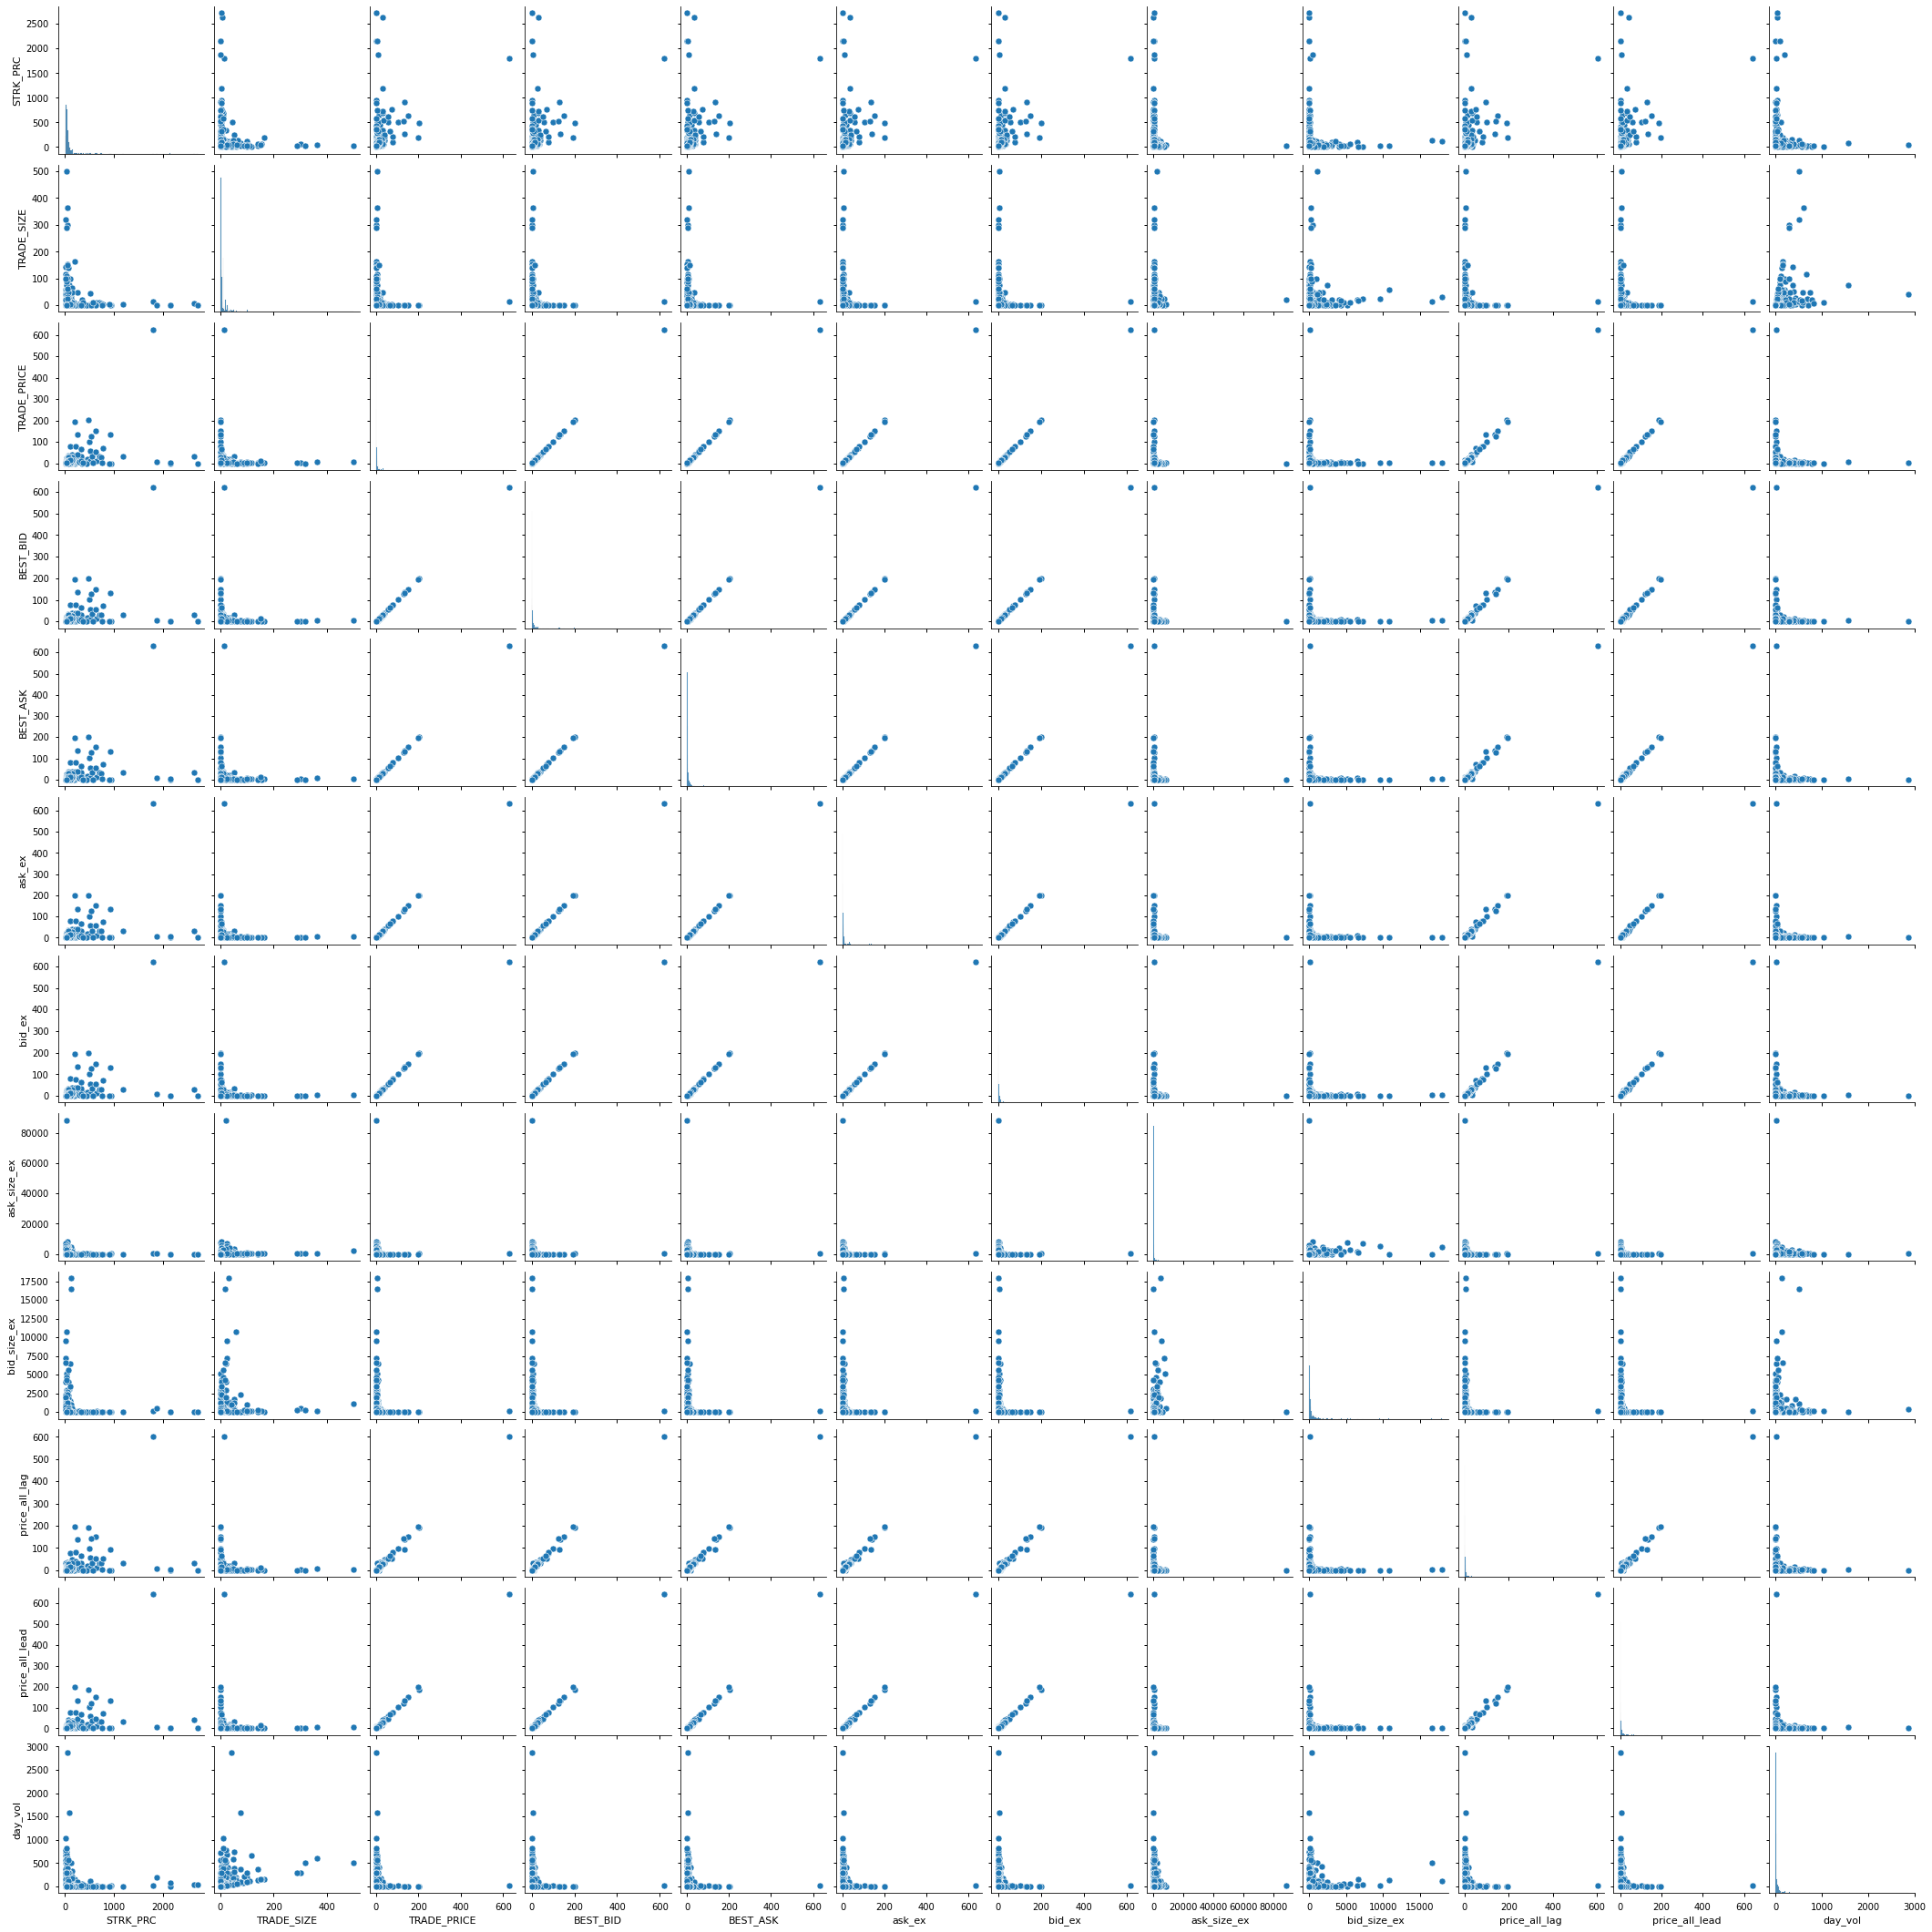

In [14]:
sample = data.sample(n=1000, random_state=seed)
sns.pairplot(
    sample,
    vars=[
        "STRK_PRC",
        "TRADE_SIZE",
        "TRADE_PRICE",
        "BEST_BID",
        "BEST_ASK",
        "ask_ex",
        "bid_ex",
        "ask_size_ex",
        "bid_size_ex",
        "price_all_lag",
        "price_all_lead",
        "day_vol",
    ],
)


### Correlation with target 🎲

In [15]:
sort_criteria = corr["buy_sell"].abs().sort_values(ascending=False)
corr_target = corr.sort_values("buy_sell", ascending=False)["buy_sell"]
corr_target.loc[sort_criteria.index].to_frame()


,buy_sell
buy_sell,1.000000
ask_size_ex,0.047890
bid_size_ex,-0.046578
STRK_PRC,0.019091
day_vol,0.012121
TRADE_SIZE,0.009560
price_ex_lead,0.008749
price_all_lead,0.006131
TRADE_PRICE,0.005401
price_ex_lag,0.005335


**Observation:**
* Overall correlations are relatively low. Typical for financial data due to low signal-to-noise ratio.
* Size-related features like `ask_size_ex` or `bid_size_ex` have the highest correlation with the target. Thus, can be promising to be included in the model. Consider size features when constructing feature sets.
* Features like `optionid`, `order_id`, and `SEQUENCE_NUMBER` are also among the features with the highest correlations. Remove them, as the correlation is misleading.

In [16]:
# remove some columns, which will NOT be used in model
data.drop(columns=["optionid"], inplace=True)


### Collinearity of features 🎲

In [17]:
# adapted from here: https://www.kaggle.com/code/willkoehrsen/featuretools-for-good
threshold = 0.975
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.975
to_drop = [column for column in upper.columns if any(abs(upper[column]) > threshold)]

print(to_drop)


['BEST_BID', 'ask_ex', 'bid_ex', 'price_all_lag', 'price_ex_lead', 'price_ex_lag']


**Observation:**
- Columns suggested for removal are intuitive
- Do not blindly remove columns, but preserve a pattern or groups

In [18]:
# Set the threshold
threshold = 0.975

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corr:
    above_threshold_vars[col] = list(corr.index[corr[col] > threshold])


In [19]:
pd.Series(above_threshold_vars)


STRK_PRC                                                 [STRK_PRC]
TRADE_SIZE                                             [TRADE_SIZE]
TRADE_PRICE       [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_BID          [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_ASK                                                 [BEST_ASK]
ask_ex            [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_ex            [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_size_ex                                           [bid_size_ex]
ask_size_ex                                           [ask_size_ex]
price_all_lead                                     [price_all_lead]
price_all_lag     [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
optionid                                                 [optionid]
day_vol                                                   [day_vol]
price_ex_lead     [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
price_ex_lag      [TRADE_PRICE, BEST_BID, ask_ex

**Observations:**
* Some columns are highly correlated. This is very intuitive.
* It seems problematic to include both `BEST_BID` and `bid_ex`. This is also true for `BEST_ASK` and `ask_ex`. `price_all_lead` and `price_all_lag` seem to be less problematic.
* Define feature sets so that the number of highly correlated variables is minimized. But maintain groups so that a comparsion with classical rules is still possible.

## $t$-SNE

Project data down using [t-SNE](https://lvdmaaten.github.io/tsne/). Also look at [umap algorithm](https://github.com/lmcinnes/umap), which is a similar effort. 

This [post](https://distill.pub/2016/misread-tsne/) gives some intuition on the parameters.

In [20]:
data.head()

,QUOTE_DATETIME,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,...,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,day_vol,price_ex_lead,price_ex_lag,issue_type,myn,buy_sell
3249281,2006-09-06 15:15:23,YNU,2008-01-19,5.0,C,5,2.05,1.95,2.05,2.05,...,113.0,186.0,1.90,2.20,5.0,2.20,2.20,0,1.225000,1
11026460,2009-01-30 14:21:48,UFB,2009-05-16,22.5,P,5,5.30,5.20,5.30,5.30,...,665.0,5.0,5.10,4.90,5.0,4.90,4.00,0,1.119125,-1
11754654,2009-04-06 13:43:46,UZK,2009-04-18,55.0,C,1,0.20,0.10,0.20,0.20,...,480.0,307.0,0.15,0.15,1.0,0.12,0.07,0,0.837000,1
12792033,2009-07-07 09:46:26,ASJ,2009-09-19,16.0,C,1,3.00,2.95,3.00,3.00,...,951.0,10.0,2.70,2.65,10.0,2.70,3.90,0,1.068437,-1
27061954,2013-04-09 11:29:28,GG,2013-04-20,36.0,P,1,3.71,3.65,3.75,3.75,...,164.0,21.0,3.65,4.80,2.0,3.65,2.81,0,1.111969,1


In [21]:
sample = data.select_dtypes(include= np.number).fillna(0).drop(columns=["buy_sell"])

In [ ]:
tsne = TSNE(
        n_components=2,
        init="random",
        random_state=0,
        perplexity=30,
        learning_rate="auto",
        n_iter=300,
)
Y = tsne.fit_transform(sample)

In [ ]:
dims = pd.DataFrame(Y, columns=["x", "y"], index=data.index)
dims["class"] = data["buy_sell"]

In [ ]:
dims["class"] = data.buy_sell

In [ ]:
fig, ax = plt.subplots(1, figsize=ratio)
scatter = plt.scatter(
    dims["x"], dims["y"], 
    c=dims["class"], cmap=plt.cm.rainbow)
plt.setp(ax, xticks=[], yticks=[])
plt.title('t-SNE of dataset')
plt.legend(handles=scatter.legend_elements()[0], labels=["-1","1"])

In [ ]:
del sample
del dims

Unfortunately, **no** clear pattern visible.

## Preparation 🥗

### Time features ⏰

In [23]:
# apply positional encoding to dates
data["date_month_sin"] = np.sin(2 * np.pi * data["QUOTE_DATETIME"].dt.month / 12)
data["date_month_cos"] = np.cos(2 * np.pi * data["QUOTE_DATETIME"].dt.month / 12)

days_in_month = 31  # at max :-)
data["date_day_sin"] = np.sin(2 * np.pi * data["QUOTE_DATETIME"].dt.day / days_in_month)
data["date_day_cos"] = np.cos(2 * np.pi * data["QUOTE_DATETIME"].dt.day / days_in_month)

# time (daily)
seconds_in_day = 24 * 60 * 60
seconds = (
    data["QUOTE_DATETIME"] - data["QUOTE_DATETIME"].dt.normalize()
).dt.total_seconds()

data["date_time_sin"] = np.sin(2 * np.pi * seconds / seconds_in_day)
data["date_time_cos"] = np.cos(2 * np.pi * seconds / seconds_in_day)

# weekday
days_in_week = 7
data["date_weekday_sin"] = np.sin(
    2 * np.pi * data["QUOTE_DATETIME"].dt.dayofweek / days_in_week
)
data["date_weekday_cos"] = np.cos(
    2 * np.pi * data["QUOTE_DATETIME"].dt.dayofweek / days_in_week
)

# time to maturity
data["ttm"] = (
    data["EXPIRATION"].dt.to_period("M") - data["QUOTE_DATETIME"].dt.to_period("M")
).apply(lambda x: x.n)

# day, month and year
data["day"] = data["QUOTE_DATETIME"].dt.day
data["month"] = data["QUOTE_DATETIME"].dt.month
data["year"] = data["QUOTE_DATETIME"].dt.year
data["date"] = data["QUOTE_DATETIME"].dt.date


### Binned features 🥫

Bin features similarily to how they are used in the robustness tests.

In [24]:
bins_tradesize = [0, 1, 3, 5, 11, np.inf]
trade_size_labels = ["(0,1]", "(1,3]", "(3,5]", "(5,11]", ">11"]
data["TRADE_SIZE_binned"] = pd.cut(
    data["TRADE_SIZE"], bins_tradesize, labels=trade_size_labels
)

bins_years = [2004, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
year_labels = [
    "2005-2007",
    "2008-2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
]
data["year_binned"] = pd.cut(data["year"], bins_years, labels=year_labels)

bins_ttm = [-1, 1, 2, 3, 6, 12, np.inf]
ttm_labels = [
    "ttm <= 1 month",
    "ttm (1-2] month",
    "ttm (2-3] month",
    "ttm (3-6] month",
    "ttm (6-12] month",
    "ttm > 12 month",
]
data["ttm_binned"] = pd.cut(data["ttm"], bins_ttm, labels=ttm_labels)


### Trade features 💴
Construct features that are used in classical rules.

In [25]:
# Calculate change similar to (reverse) tick rule
data["chg_ex_lead"] = data["TRADE_PRICE"] - data["price_ex_lead"]
data["chg_ex_lag"] = data["TRADE_PRICE"] - data["price_ex_lag"]
data["chg_all_lead"] = data["TRADE_PRICE"] - data["price_all_lead"]
data["chg_all_lag"] = data["TRADE_PRICE"] - data["price_all_lag"]

# Midspread
mid_ex = 0.5 * (data["ask_ex"] + data["bid_ex"])
mid_best = 0.5 * (data["BEST_ASK"] + data["BEST_BID"])
data["mid_ex"] = mid_ex
data["mid_best"] = mid_best

# spread (abs)
spread_ex = data["ask_ex"] - data["bid_ex"]
spread_best = data["BEST_ASK"] - data["BEST_BID"]

# depth rule (usually only applied to mid spread transactions)
data["bid_ask_size_ratio_ex"] = data["bid_size_ex"] / data["ask_size_ex"]

# Degree how much trade size is filled -> similar to trade size rule
# Trade size rule would just classify if
data["rel_bid_size_ex"] = data["TRADE_SIZE"] / data["bid_size_ex"]
data["rel_ask_size_ex"] = data["TRADE_SIZE"] / data["ask_size_ex"]

# EMO / CLNV / quote rule
data["prox_ex"] = (data["TRADE_PRICE"] - mid_ex) / (0.5 * spread_ex)
data["prox_best"] = (data["TRADE_PRICE"] - mid_best) / (0.5 * spread_best)

# custom
data["price_rel_nbo"] = (data["TRADE_PRICE"] - data["BEST_ASK"]) / (
    data["BEST_ASK"] - mid_best
)
data["price_rel_nbb"] = (data["TRADE_PRICE"] - data["BEST_BID"]) / (
    mid_best - data["BEST_BID"]
)
data["bid_ask_ratio_ex"] = data["bid_ex"] / data["ask_ex"]
data["depth_ex"] = data["bid_size_ex"] - data["ask_size_ex"]

data["abs_mid_ex"] = data["TRADE_PRICE"] - mid_ex
data["abs_mid_BEST"] = data["TRADE_PRICE"] - mid_best

data["spread_ex"] = spread_ex
data["spread_best"] = spread_best


### Underlying features 🫀

In [26]:
data["symbol_is_index"] = data["ROOT"].str.startswith("^").astype(int)


In [27]:
data.head()


,QUOTE_DATETIME,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,...,prox_best,price_rel_nbo,price_rel_nbb,bid_ask_ratio_ex,depth_ex,abs_mid_ex,abs_mid_BEST,spread_ex,spread_best,symbol_is_index
3249281,2006-09-06 15:15:23,YNU,2008-01-19,5.0,C,5,2.05,1.95,2.05,2.05,...,1.000000,0.0,2.00000,0.951220,-73.0,0.050,0.050,0.10,0.10,0
11026460,2009-01-30 14:21:48,UFB,2009-05-16,22.5,P,5,5.30,5.20,5.30,5.30,...,1.000000,0.0,2.00000,0.981132,660.0,0.050,0.050,0.10,0.10,0
11754654,2009-04-06 13:43:46,UZK,2009-04-18,55.0,C,1,0.20,0.10,0.20,0.20,...,1.000000,0.0,2.00000,0.500000,173.0,0.050,0.050,0.10,0.10,0
12792033,2009-07-07 09:46:26,ASJ,2009-09-19,16.0,C,1,3.00,2.95,3.00,3.00,...,1.000005,0.0,2.00001,0.983333,941.0,0.025,0.025,0.05,0.05,0
27061954,2013-04-09 11:29:28,GG,2013-04-20,36.0,P,1,3.71,3.65,3.75,3.75,...,0.200000,-0.8,1.20000,0.973333,143.0,0.010,0.010,0.10,0.10,0


### Categorical features 🎰

### Visualization helper 🐜

In [28]:
def plot_kde_target(var_name: str, clip: Optional[List[float]] = None):
    """
  Plot kde plots for buys (+1) and sells (-1) with regard to \
  the feature 'var_name'.

   Args:
      var_name (str): name of the feature
      clip (Optional[List[float]], optional): clipping range. Defaults to None.
  """
    corr_var = data["buy_sell"].corr(data[var_name])

    median_sell = data[data["buy_sell"] == -1][var_name].median()
    median_buy = data[data["buy_sell"] == 1][var_name].median()

    _, ax = plt.subplots()
    for i in [-1, 1]:
        sns.kdeplot(
            data=data[data["buy_sell"] == i],
            x=var_name,
            clip=clip,
            label=str(i),
            cumulative=False,
            common_grid=True,
        )
    ax.title.set_text(f"Distribution of '{var_name}'")
    ax.legend()
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
    plt.show()
    print(
        f"The correlation between '{var_name}' and the 'buy_sell' is {corr_var: 0.4f}"
    )
    print(f"Median value of sells = {median_sell: 0.4f}")
    print(f"Median value of buys = {median_buy: 0.4f}")


In [29]:
def plot_kde_target_comparsion(
    var_name: str,
    clip: Optional[List[float]] = None,
    years: List[int] = [2006, 2010, 2013],
) -> None:
    """
    Plot several kde plots side by side for the feature.

    Args:
        var_name (str): name of the feature
        clip (Optional[List[float]], optional): clipping range. Defaults to None.
        years (List[int], optional): years to compare. Defaults to [2006, 2010, 2013].
    """
    fig, ax = plt.subplots(nrows=1, ncols=len(years), figsize=(18, 4))

    fig.suptitle(f"Distribution of `{var_name}`")

    for y, year in enumerate(years):
        for i in [-1, 1]:
            sns.kdeplot(
                data=data[(data["buy_sell"] == i) & (data["year"] == year)],
                x=var_name,
                clip=clip,
                # supress any other but first label using '_'
                # see https://stackoverflow.com/a/44633022/5755604
                label="_" * y + str(i),
                cumulative=False,
                common_grid=True,
                ax=ax[y],
            )
            ax[y].xaxis.label.set_text(str(year))

    fig.legend()


In [30]:
us_rec = web.DataReader("USREC", "fred", data["date"].min(), data["date"].max())


def plot_recessions() -> None:
    """
    Add recession indicator to plot and entry to legend.
    """
    l = 0
    month = relativedelta.relativedelta(months=+1)
    for date, val in us_rec["USREC"].items():
        if val == 1:
            # if boolean = 1 -> print bar until next month
            # '_' labels are ignored in legend https://stackoverflow.com/a/44633022/5755604
            plt.axvspan(
                date,
                date + month,
                edgecolor="none",
                alpha=0.25,
                label="_" * l + "recession",
            )
            l += 1


In [31]:
def plot_time_series(
    feature: Union[str, List[str]], aggregation: Union[str, List[Any]] = "count"
) -> pd.DataFrame:
    """
    Plot feature over time. Aggregate using 'aggregation'.

    Args:
        feature (Union[str, List[str]]): feature to plot.
        aggregation (Union[str, List[Any]], optional): aggregation operation. Defaults to "count".

    Returns:
        pd.DataFrame: time series
    """
    if isinstance(feature, str):
        feature = [feature]
    if isinstance(aggregation, str):
        aggregation = [aggregation]

    time_series = data[feature].groupby(data["date"]).agg(aggregation)
    time_series.columns = time_series.columns.to_flat_index()

    ax = sns.lineplot(data=time_series)
    ax.yaxis.label.set_text(" / ".join(aggregation))
    ax.title.set_text(f"'{' / '.join(feature)}' over time")
    plot_recessions()
    ax.legend()
    plt.show()

    return time_series


In [32]:
# select categorical e. g., option type and strings e. g., ticker
cat_columns = data.select_dtypes(include=["category", "object"]).columns.tolist()
print(cat_columns)

# assign "bin_" column prefix
cat_columns_bin = ["bin_" + x for x in cat_columns]

# binarize categorical similar to Borisov et al.
data[cat_columns_bin] = data[cat_columns].apply(lambda x: pd.factorize(x)[0])  # type: ignore


['ROOT', 'OPTION_TYPE', 'issue_type', 'date', 'TRADE_SIZE_binned', 'year_binned', 'ttm_binned']


## General overview 🌄

### Trade price and sizes 🤝

#### Trades over time ⌚

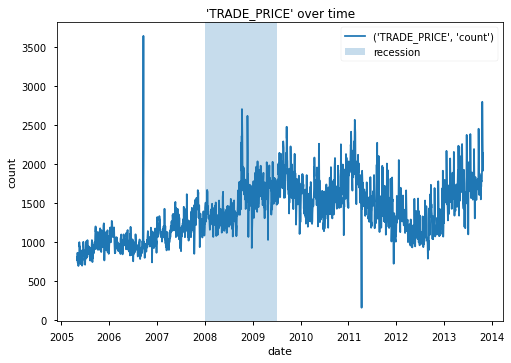

In [33]:
trades_per_day = plot_time_series("TRADE_PRICE", "count")


In [34]:
trades_per_day.iloc[:, 0].nlargest(N)


date
2006-09-19    3638
2013-10-18    2793
2008-10-10    2700
2008-11-21    2613
2011-02-18    2562
2009-09-16    2473
2009-09-18    2464
2008-11-20    2463
2013-09-20    2448
2011-01-21    2410
Name: (TRADE_PRICE, count), dtype: int64

In [35]:
trades_per_day.iloc[:, 0].nsmallest(N)


date
2011-04-11    154
2005-05-11    689
2005-06-08    693
2005-06-10    705
2005-07-01    705
2005-05-27    713
2011-12-12    718
2005-05-06    728
2006-11-24    735
2005-08-26    739
Name: (TRADE_PRICE, count), dtype: int64

**Observation:**
* Number of trades increases over time.
* There is no obvious explanation why the number of trades spikes at certain days.

#### Trade size

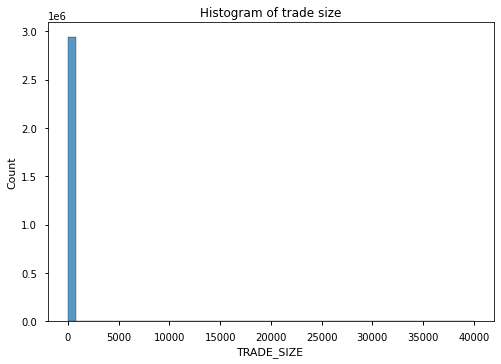

In [36]:
ax = sns.histplot(data, x="TRADE_SIZE", bins=50)  # type: ignore
ax.title.set_text("Histogram of trade size")


**Observation:**
* highly skewed with few outliers.
* Similar to the price, $\log(\cdot)$ transform could help.

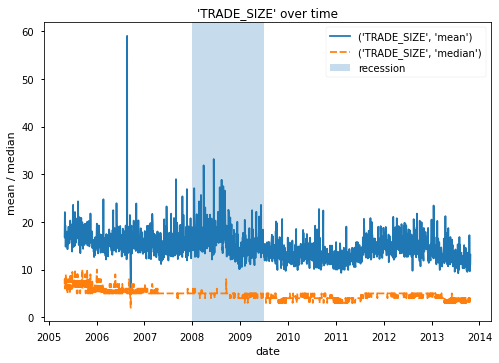

In [37]:
trades_over_time = plot_time_series("TRADE_SIZE", ["mean", "median"])


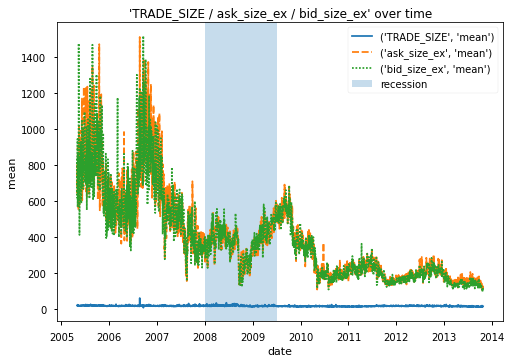

In [38]:
trade_ask_bid_size = plot_time_series(
    ["TRADE_SIZE", "ask_size_ex", "bid_size_ex"], "mean"
)


**Observation:**
* There is a slow downward trend in `TRADE_SIZE` (mean).
* Controversely, the number of trades per day (mean) increases over time.
* Market share of ISE has decrease over time, as reported in https://www.sifma.org/wp-content/uploads/2022/03/SIFMA-Insights-Market-Structure-Compendium-March-2022.pdf. 

In [39]:
data["TRADE_SIZE"].describe()


count    2.946810e+06
mean     1.461753e+01
std      7.499849e+01
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.000000e+01
max      4.000000e+04
Name: TRADE_SIZE, dtype: float64

In [40]:
data[data["TRADE_SIZE"].max() == data["TRADE_SIZE"]]


,QUOTE_DATETIME,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,...,spread_ex,spread_best,symbol_is_index,bin_ROOT,bin_OPTION_TYPE,bin_issue_type,bin_date,bin_TRADE_SIZE_binned,bin_year_binned,bin_ttm_binned
3160192,2006-08-22 14:03:47,QAV,2006-10-21,32.0,P,40000,0.1,0.05,0.1,0.1,...,0.05,0.05,0,510,1,1,129,3,0,3


In [41]:
data.nlargest(N, "TRADE_SIZE", keep="first").T


,3160192,8588493,17827624,12066837,11084912,12491904,9007495,17469012,9603295,1952893
QUOTE_DATETIME,2006-08-22 14:03:47,2008-06-13 11:44:24,2010-09-27 15:46:44,2009-05-04 13:55:17,2009-02-05 12:55:14,2009-06-09 15:20:32,2008-07-29 14:38:31,2010-08-25 10:58:15,2008-09-30 10:18:50,2006-02-22 13:47:15
ROOT,QAV,KEB,SMN1,URP,GLD,SZC,SFB,SPY,SPY,QQQ
EXPIRATION,2006-10-21 00:00:00,2010-01-16 00:00:00,2012-01-21 00:00:00,2009-08-22 00:00:00,2009-09-19 00:00:00,2009-06-20 00:00:00,2008-12-20 00:00:00,2010-09-30 00:00:00,2008-12-20 00:00:00,2006-05-20 00:00:00
STRK_PRC,32.0,12.5,15.0,22.5,88.0,77.0,133.0,85.0,127.0,40.0
OPTION_TYPE,P,P,C,P,C,C,C,P,P,P
...,...,...,...,...,...,...,...,...,...,...
bin_issue_type,1,0,1,0,1,1,1,1,1,1
bin_date,129,1788,574,1814,68,936,1011,1526,1136,2117
bin_TRADE_SIZE_binned,3,3,3,3,3,3,3,3,3,3
bin_year_binned,0,1,1,1,1,1,1,1,1,0


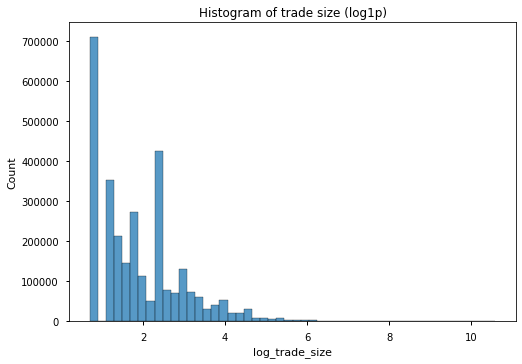

In [42]:
data["log_trade_size"] = np.log1p(data["TRADE_SIZE"])
ax = sns.histplot(data, x="log_trade_size", bins=50)  # type: ignore
ax.title.set_text(f"Histogram of trade size (log1p)")


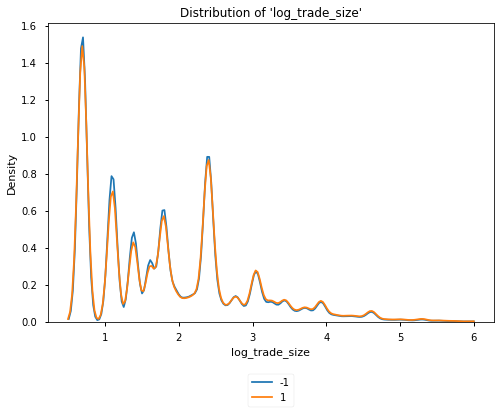

The correlation between 'log_trade_size' and the 'buy_sell' is  0.0162
Median value of sells =  1.7918
Median value of buys =  1.7918


In [43]:
plot_kde_target("log_trade_size", clip=[0, 6])


**Observation:**
- Size features do hardly profit from a $\log$ transform. Might want to keep as-is.

#### Trade price

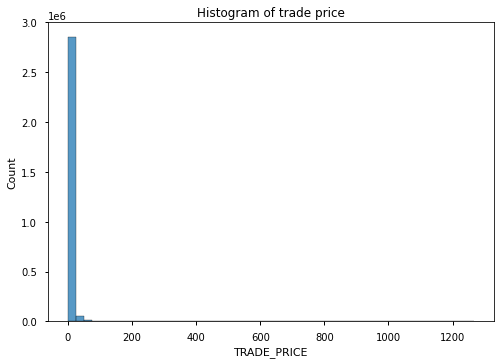

In [44]:
ax = sns.histplot(data, x="TRADE_PRICE", bins=50)  # type: ignore
ax.title.set_text("Histogram of trade price")


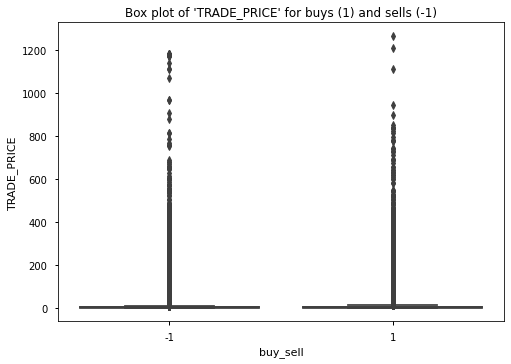

In [45]:
ax = sns.boxplot(data=data, x="buy_sell", y="TRADE_PRICE")
ax.title.set_text("Box plot of 'TRADE_PRICE' for buys (1) and sells (-1)")


**Observations:**
* Very few, very large trade prices, many very small trade prices.
* Scaling can be problematic, if outliers affect scaling much. Try $\log(\cdot)$ transform to correct skewness of distribution. Could improve results.
* Trade price is hardly informative, as distribution is very similar.

In [46]:
data["log_trade_price"] = np.log1p(data["TRADE_PRICE"])


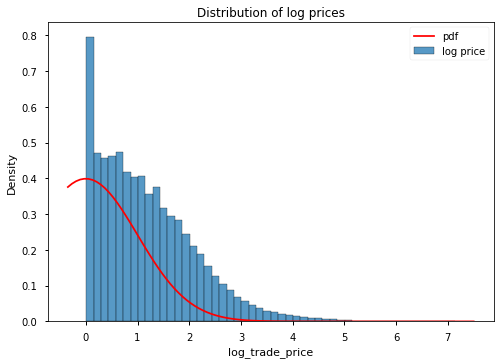

In [47]:
fig, ax = plt.subplots()

sns.histplot(data, x="log_trade_price", bins=50, stat="density", label="log price")  # type: ignore

# extract the limits for the x-axis and fit normal distributon
x0, x1 = ax.get_xlim()
x_pdf = np.linspace(x0, x1, 100)
y_pdf = stats.norm.pdf(x_pdf)

pdf = pd.DataFrame({"x": x_pdf, "y": y_pdf})
sns.lineplot(data=pdf, x="x", y="y", label="pdf", color="r")


ax.title.set_text("Distribution of log prices")
ax.legend()


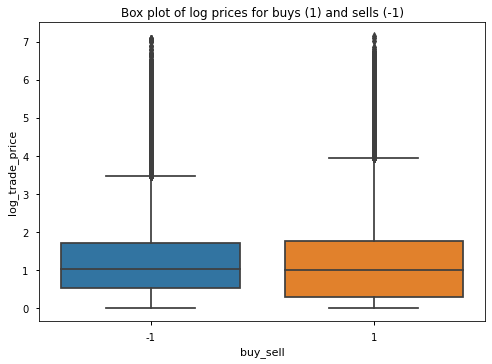

In [48]:
ax = sns.boxplot(data=data, x="buy_sell", y="log_trade_price")
ax.title.set_text("Box plot of log prices for buys (1) and sells (-1)")


In [49]:
data.nlargest(N, "TRADE_PRICE", keep="first").T


,14962176,15364463,14442297,14441737,14462547,14451647,14451656,14459254,14459252,14459239
QUOTE_DATETIME,2009-12-30 12:13:35,2010-02-05 14:29:22,2009-11-12 09:42:06,2009-11-12 09:36:19,2009-11-13 10:23:02,2009-11-12 12:57:25,2009-11-12 12:57:30,2009-11-13 09:32:16,2009-11-13 09:32:16,2009-11-13 09:32:07
ROOT,NDK,NDK,NDK,NDK,NDK,NDK,NDK,NDK,NDK,NDK
EXPIRATION,2010-09-18 00:00:00,2010-09-18 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00,2009-12-19 00:00:00
STRK_PRC,600.0,500.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0
OPTION_TYPE,C,C,C,C,C,C,C,C,C,C
...,...,...,...,...,...,...,...,...,...,...
bin_TRADE_SIZE_binned,3,3,2,0,2,1,3,2,2,1
bin_year_binned,1,1,1,1,1,1,1,1,1,1
bin_ttm_binned,5,5,2,2,2,2,2,2,2,2
log_trade_size,8.2943,5.70711,2.397895,1.609438,2.197225,0.693147,2.70805,2.397895,2.397895,0.693147


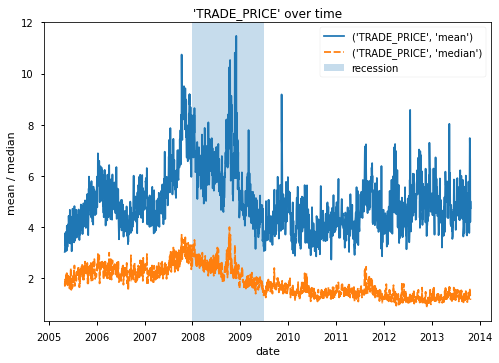

In [50]:
trade_price_over_time = plot_time_series("TRADE_PRICE", ["mean", "median"])


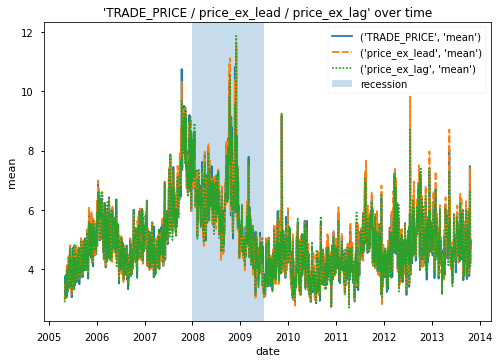

In [51]:
trade_price_over_time = plot_time_series(
    ["TRADE_PRICE", "price_ex_lead", "price_ex_lag"], "mean"
)


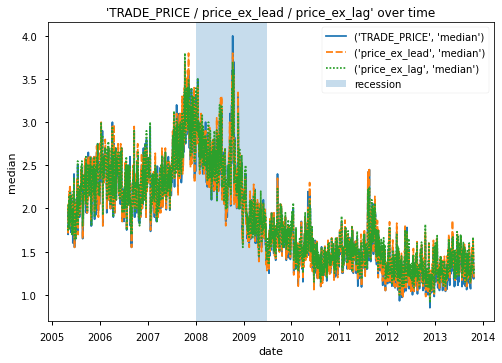

In [52]:
trade_price_over_time = plot_time_series(
    ["TRADE_PRICE", "price_ex_lead", "price_ex_lag"], "median"
)


**Observation:**
* `TRADE_PRICE` remains roughly constant over time. Median decreases over time.
* Large difference between median and mean. 

### Time to maturity ⌚

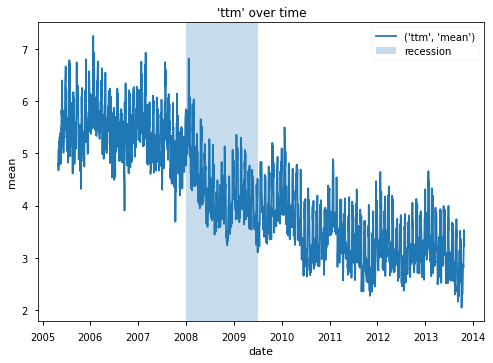

In [53]:
ttm_over_time = plot_time_series("ttm", "mean")


Text(0.5, 0.98, 'Trade Price vs. Time to Maturity')

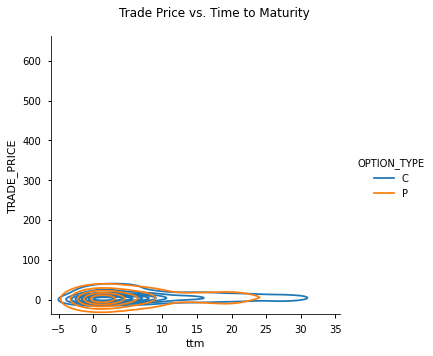

In [54]:
sample = data.sample(n=1000, random_state=seed)

plot = sns.displot(data=sample, x="ttm", y="TRADE_PRICE", kind="kde", hue="OPTION_TYPE")
plot.figure.subplots_adjust(top=0.9)
plot.figure.suptitle("Trade Price vs. Time to Maturity")


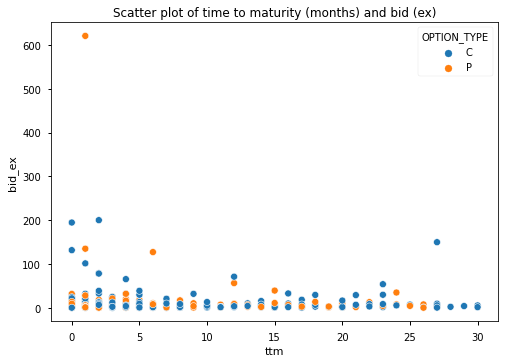

In [55]:
ax = sns.scatterplot(data=sample, x="ttm", y="bid_ex", hue="OPTION_TYPE")
ax.title.set_text("Scatter plot of time to maturity (months) and bid (ex)")


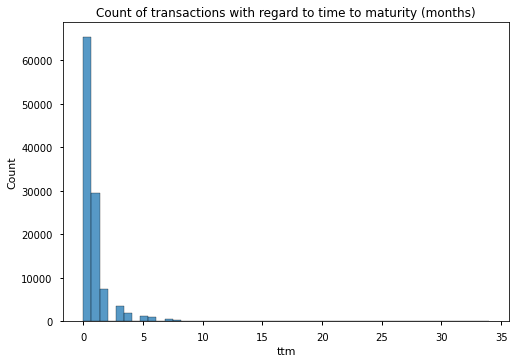

In [56]:
ax = sns.histplot(data=data[data["bid_ex"] == 0.0], x="ttm", bins=50)  # type: ignore
ax.title.set_text("Count of transactions with regard to time to maturity (months)")


**Observation:**
- Most options have a short time-to-maturity
- Binning or cut-off could be helpful

<AxesSubplot:xlabel='ttm', ylabel='Count'>

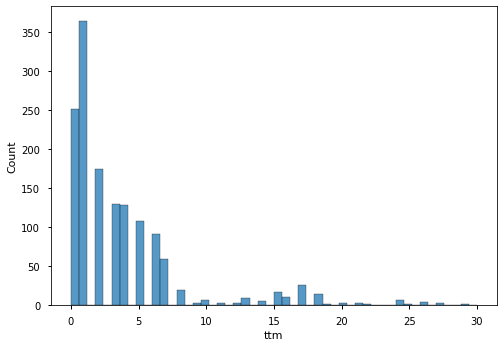

In [57]:
# TODO: ask of zero plausible?
sns.histplot(data=data[data["ask_ex"] == 0.0], x="ttm", bins=50)  # type: ignore


### Strike price

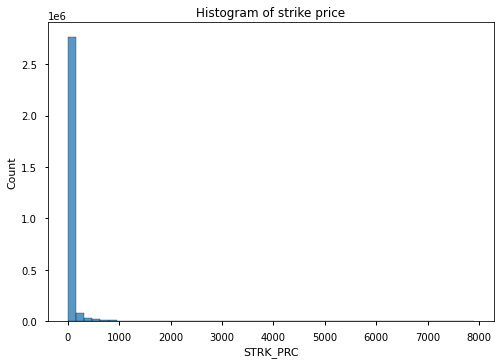

In [58]:
ax = sns.histplot(data, x="STRK_PRC", bins=50)  # type: ignore
ax.title.set_text("Histogram of strike price")


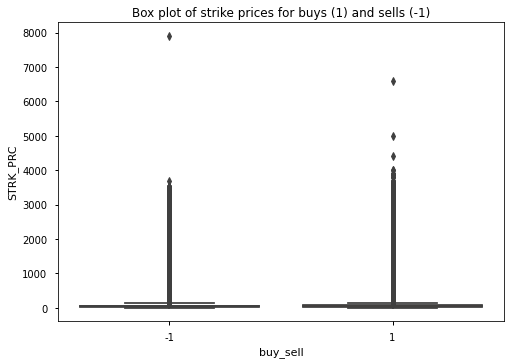

In [59]:
ax = sns.boxplot(data=data, x="buy_sell", y="STRK_PRC")
ax.title.set_text("Box plot of strike prices for buys (1) and sells (-1)")


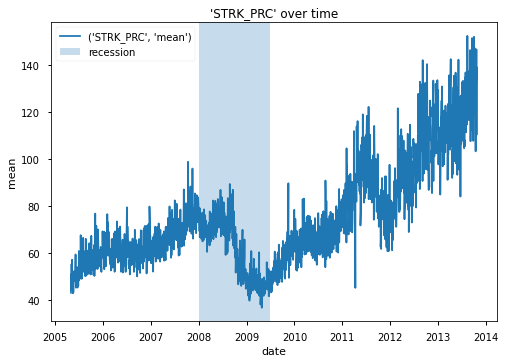

In [60]:
strike_over_time = plot_time_series("STRK_PRC", "mean")


**Observation:**
- Distribution of strike price is highly skewed
- Average strike price grows over time. Thus, very large and previously unobserved trade prices could be part of the test set, but not in the train set.
- Try $\log$

In [61]:
data["log_strk_prc"] = np.log1p(data["STRK_PRC"])


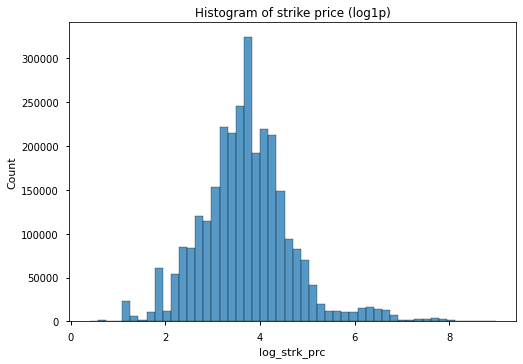

In [62]:
ax = sns.histplot(data, x="log_strk_prc", bins=50)  # type: ignore
ax.title.set_text("Histogram of strike price (log1p)")


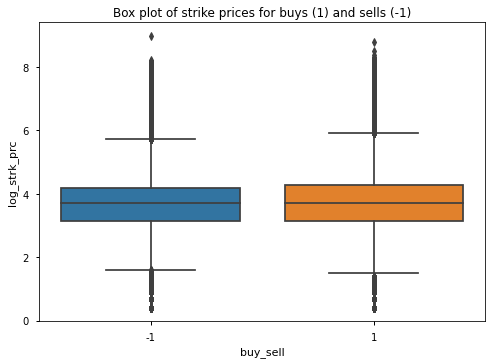

In [63]:
ax = sns.boxplot(data=data, x="buy_sell", y="log_strk_prc")
ax.title.set_text("Box plot of strike prices for buys (1) and sells (-1)")


### Buy Sell 👛

In [64]:
ratio_buy_sell = data["buy_sell"].value_counts() / data["buy_sell"].count()
ratio_buy_sell.head()


-1    0.529536
 1    0.470464
Name: buy_sell, dtype: float64

**Observation:**
* Ratios similar to the one reported in Grauer et. al. Yet not identical as calculation is done on a sample.
* As both classes have a $\approx~0.5$ probability, I would not rebalance. Rebalancing through sampling etc. itself has a bias.
* Ratios seem to be stable over time (see below). Thus, distribution is similar for training, validation, and test set.
* With regard to time-to-maturity the distribution changes slightly for longer periods.

#### By option type

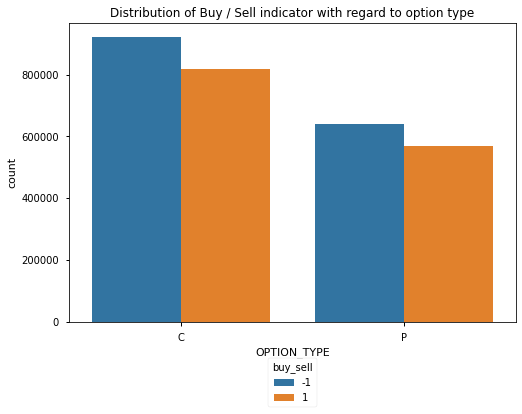

In [65]:
ax = sns.countplot(data=data, x="OPTION_TYPE", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to option type")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))


#### By year

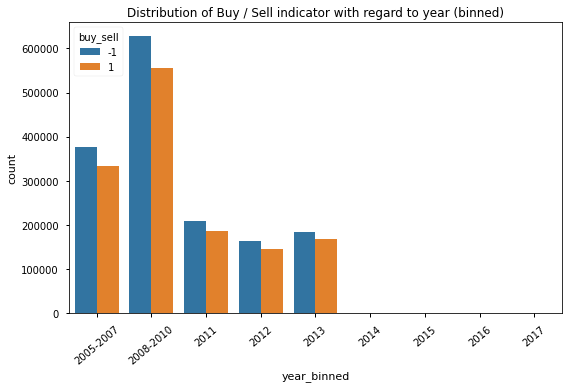

In [66]:
ax = sns.countplot(data=data, x="year_binned", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to year (binned)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="center")
plt.tight_layout()
plt.show()


#### By time time to maturity

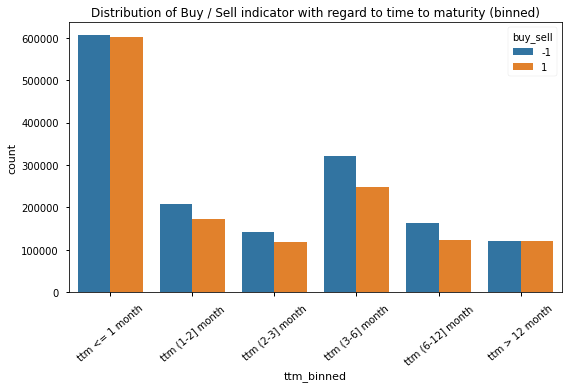

In [67]:
ax = sns.countplot(data=data, x="ttm_binned", hue="buy_sell")
ax.title.set_text(
    "Distribution of Buy / Sell indicator with regard to time to maturity (binned)"
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="center")
plt.tight_layout()
plt.show()


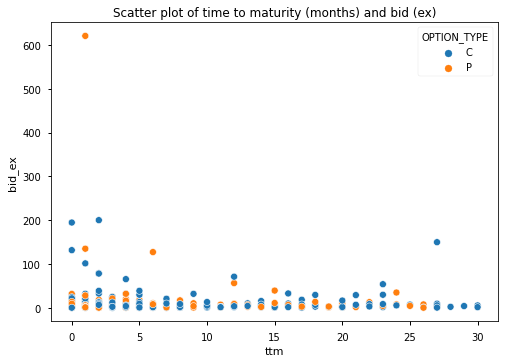

In [68]:
ax = sns.scatterplot(data=sample, x="ttm", y="bid_ex", hue="OPTION_TYPE")
ax.title.set_text("Scatter plot of time to maturity (months) and bid (ex)")


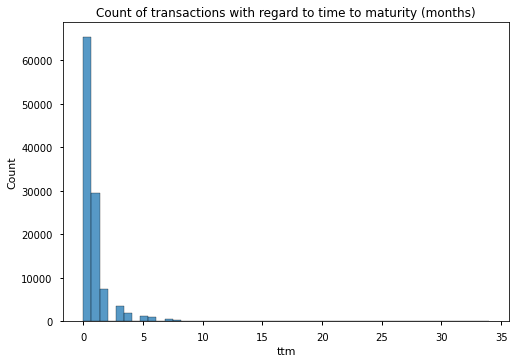

In [69]:
ax = sns.histplot(data=data[data["bid_ex"] == 0.0], x="ttm", bins=50)  # type: ignore
ax.title.set_text("Count of transactions with regard to time to maturity (months)")


<AxesSubplot:xlabel='ttm', ylabel='Count'>

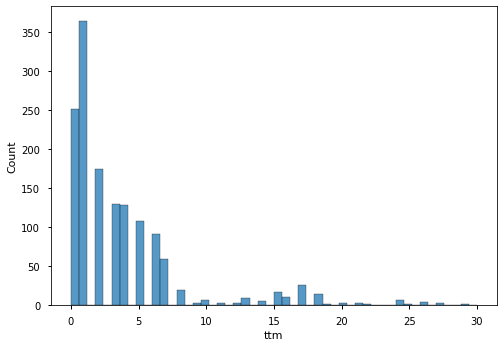

In [70]:
# TODO: ask of zero plausible?
sns.histplot(data=data[data["ask_ex"] == 0.0], x="ttm", bins=50)  # type: ignore


#### Over time

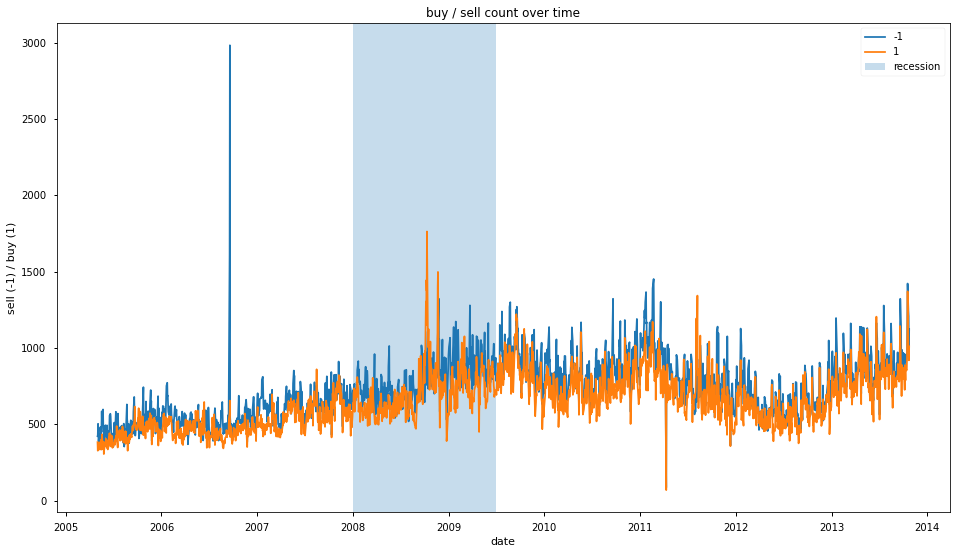

In [71]:
trades_over_time = (
    data.groupby(data["date"])["buy_sell"].value_counts().unstack(fill_value=0)
)
ax = trades_over_time.plot(
    kind="line",
    figsize=ratio,
    title="buy / sell count over time",
    xlabel="date",
    ylabel="sell (-1) / buy (1)",
)
plot_recessions()
ax.legend()
plt.show()


### $n$ most frequent symbols, indices, and special codes 🔢

See how frequent symbols are, as they can lead to an explosion in cardinality.

<AxesSubplot:xlabel='Count', ylabel='Count'>

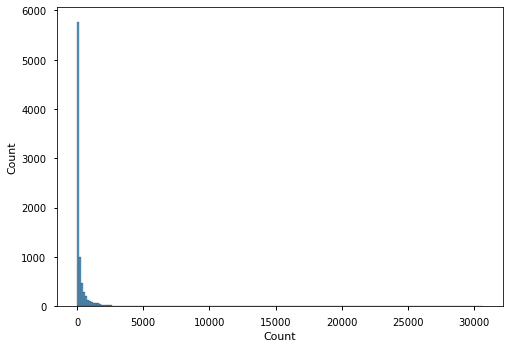

In [72]:
frequency_symbols = data["ROOT"].value_counts().reset_index(name="Count")
frequency_symbols.rename(columns={"index": "Symbol"}, inplace=True)
frequency_symbols.sort_values("Count", ascending=True)
sns.histplot(data=frequency_symbols, x="Count", bins=200)


In [73]:
frequency_symbols[frequency_symbols["Count"] <= 5].count()


Symbol    1162
Count     1162
dtype: int64

In [74]:
frequency_symbols


,Symbol,Count
0,SPY,30678
1,AAPL,20141
2,GLD,20061
3,IWM,14731
4,RUT,14028
...,...,...
8662,XAR,1
8663,KDW,1
8664,VZY,1
8665,BYT,1


,Symbol,Count
0,SPY,30678
1,AAPL,20141
2,GLD,20061
3,IWM,14731
4,RUT,14028
5,QQQ,11406
6,DIA,11057
7,GOOG,10261
8,NDX,10236
9,GDX,9825


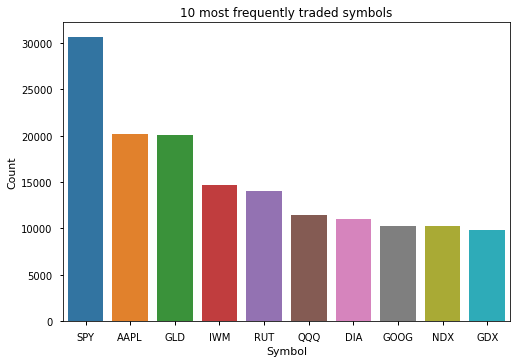

In [75]:
most_frequent_symbols = data["ROOT"].value_counts().head(N).reset_index(name="Count")
most_frequent_symbols.rename(columns={"index": "Symbol"}, inplace=True)

ax = sns.barplot(data=most_frequent_symbols, x="Symbol", y="Count")
ax.title.set_text(f"{N} most frequently traded symbols")

most_frequent_symbols.head(N)


In [76]:
list_freq_symbols = most_frequent_symbols.Symbol.tolist()


In [77]:
frequent_symbols_over_time = data[data["ROOT"].isin(list_freq_symbols)]


In [78]:
frequent_symbols_trades_per_day = (
    frequent_symbols_over_time.groupby(
        [frequent_symbols_over_time.QUOTE_DATETIME.dt.to_period("m"), "ROOT"]
    )["TRADE_SIZE"]
    .count()
    .reset_index()
    .rename(columns={"TRADE_SIZE": "count", "QUOTE_DATETIME": "date", "ROOT": "Symbol"})
)


In [79]:
frequent_symbols_over_time = (
    frequent_symbols_trades_per_day.groupby(["date", "Symbol"])["count"]
    .first()
    .unstack()
)


<AxesSubplot:title={'center':'10 most frequently traded underlyings over time'}, xlabel='date'>

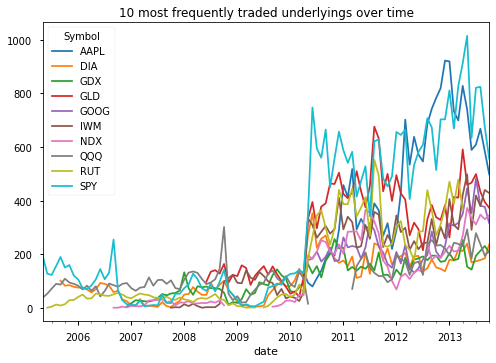

In [80]:
frequent_symbols_over_time.plot(
    kind="line", title=f"{N} most frequently traded underlyings over time"
)


In [81]:
root_time_train = pd.read_parquet(
    "gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_extended_60.parquet",
    columns=["QUOTE_DATETIME", "ROOT"],
)
root_time_val = pd.read_parquet(
    "gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_extended_20.parquet",
    columns=["QUOTE_DATETIME", "ROOT"],
)
root_time_test = pd.read_parquet(
    "gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_extended_20.parquet",
    columns=["QUOTE_DATETIME", "ROOT"],
)

roots_over_time = pd.concat([root_time_train, root_time_val, root_time_test])


In [82]:
# randomly sample N symbols and check when they appear for the first and last time
roots_sample = (
    roots_over_time.groupby("ROOT")["QUOTE_DATETIME"]
    .agg(["min", "max"])
    .reset_index()
    .sample(N)
    .T
)


In [83]:
# see 2.0-mb-data_preprocessing_loading_splitting.ipynb
dti = pd.date_range("2005-05-02", "2017-05-31", freq="d")
plot_df = pd.DataFrame(index=dti)

for i, col in enumerate(roots_sample.columns):
    plot_df[roots_sample.iloc[0, i]] = np.where(
        np.logical_and(
            plot_df.index >= roots_sample.iloc[1, i],
            plot_df.index <= roots_sample.iloc[2, i],
        ),
        i/N,
        np.nan,
    )


Text(0.5, 1.0, 'roots over time (min / max appearance)')

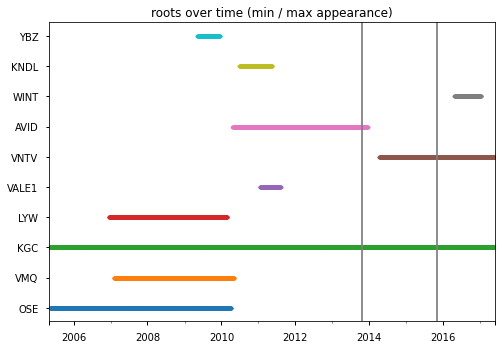

In [84]:
ax = plot_df.plot(legend=False, style=".")
ax.set_yticks(np.linspace(0,(N-1) / N,N))
ax.set_yticklabels(plot_df.columns)
# beginning of validation and test set
ax.axvline("2013-10-25", color="gray")
ax.axvline("2015-11-06", color="gray")
ax.set_title("roots over time (min / max appearance)")

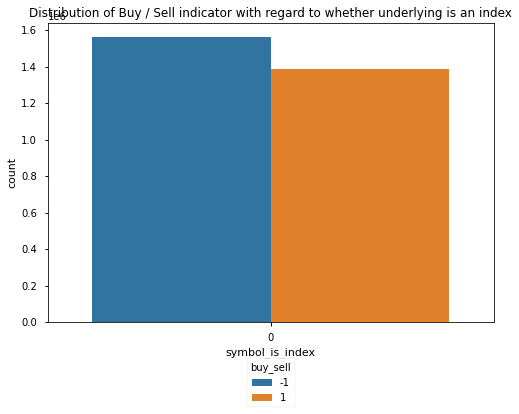

In [85]:
# TODO: investigate why there is no True group
ax = sns.countplot(data=data, x="symbol_is_index", hue="buy_sell")
ax.title.set_text(
    "Distribution of Buy / Sell indicator with regard to whether underlying is an index"
)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))


In [86]:
ratios_is_index = (
    data.groupby(["symbol_is_index", "buy_sell"])["buy_sell"].count()
    / data.groupby(["symbol_is_index"])["buy_sell"].count()
)
ratios_is_index.head()


symbol_is_index  buy_sell
0                -1          0.529536
                  1          0.470464
Name: buy_sell, dtype: float64

**Observation:**
- Feature can be important, as it's much more likely for trade to be sell, rather than buy, if and only if the underlying is no index option.
- Difference isn't too pronounced and could be due to sampling effects.

In [87]:
data["issue_type"].value_counts(dropna=False)


0       2244377
%        482280
F        173979
A         42042
None       3044
7          1088
Name: issue_type, dtype: int64

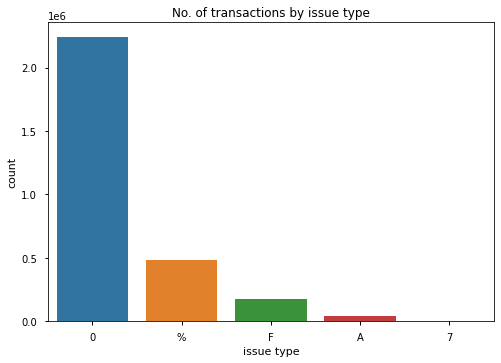

In [88]:
ax = sns.countplot(data=data, x="issue_type")
ax.title.set_text("No. of transactions by issue type")
ax.xaxis.label.set_text("issue type")


###  Ask and bid👨‍⚖️

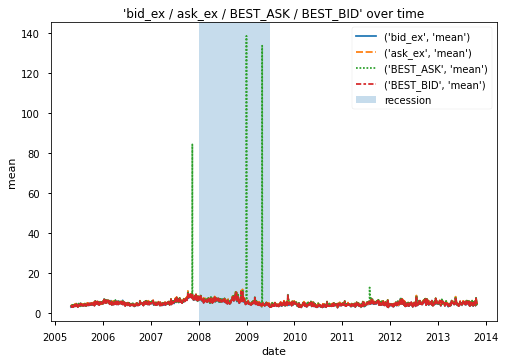

In [89]:
bid_ask_over_time = plot_time_series(
    ["bid_ex", "ask_ex", "BEST_ASK", "BEST_BID"], "mean"
)


#### Ask

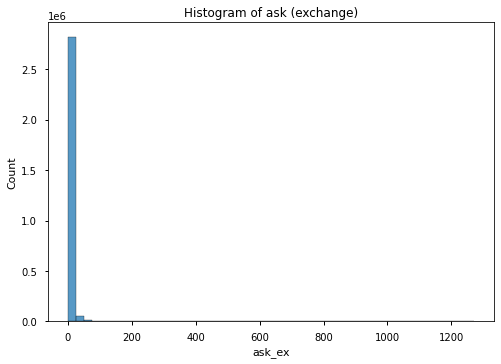

In [90]:
ax = sns.histplot(data, x="ask_ex", bins=50)  # type: ignore
ax.title.set_text("Histogram of ask (exchange)")


**Observation:**
* Distribution is highly skewed, try correction with $\log$

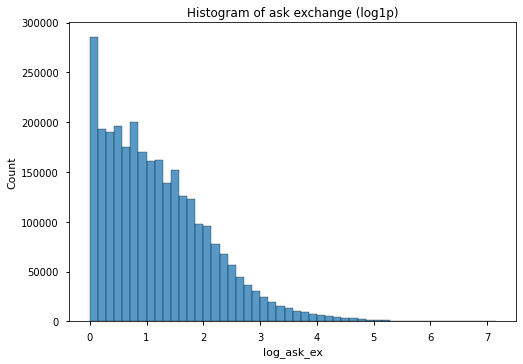

In [91]:
data["log_ask_ex"] = np.log1p(data["ask_ex"])
ax = sns.histplot(data, x="log_ask_ex", bins=50)  # type: ignore
ax.title.set_text(f"Histogram of ask exchange (log1p)")


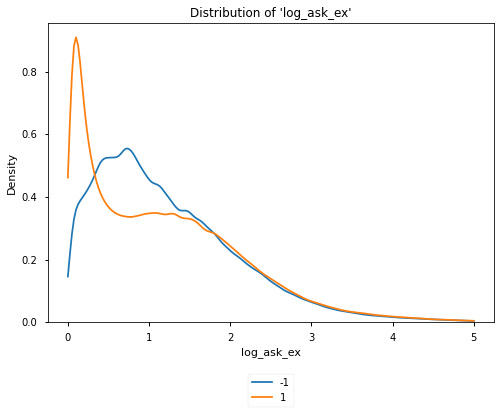

The correlation between 'log_ask_ex' and the 'buy_sell' is -0.0332
Median value of sells =  1.0578
Median value of buys =  1.0260


In [92]:
plot_kde_target("log_ask_ex", clip=[0, 5])


**Observation:**
* Applying a $\log$ transform leads to a easily distinguishable distribution

#### Bid

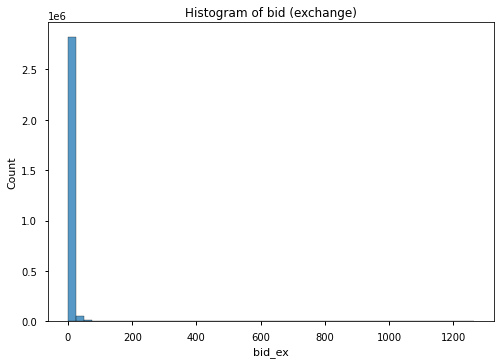

In [93]:
ax = sns.histplot(data, x="bid_ex", bins=50)  # type: ignore
ax.title.set_text("Histogram of bid (exchange)")


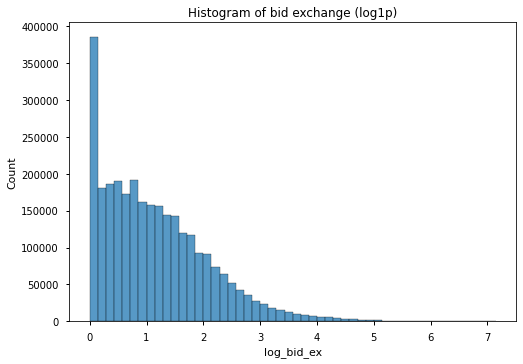

In [94]:
data["log_bid_ex"] = np.log1p(data["bid_ex"])
ax = sns.histplot(data, x="log_bid_ex", bins=50)  # type: ignore
ax.title.set_text(f"Histogram of bid exchange (log1p)")


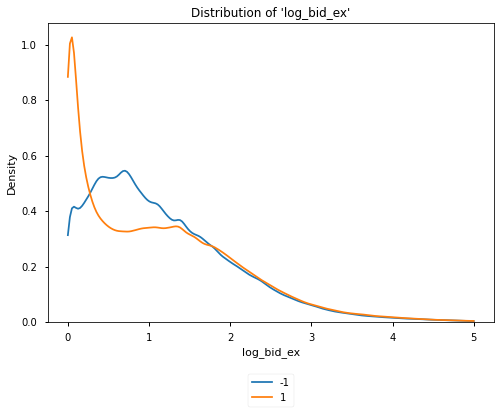

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.0339
Median value of sells =  1.0116
Median value of buys =  0.9746


In [95]:
plot_kde_target("log_bid_ex", clip=[0, 5])


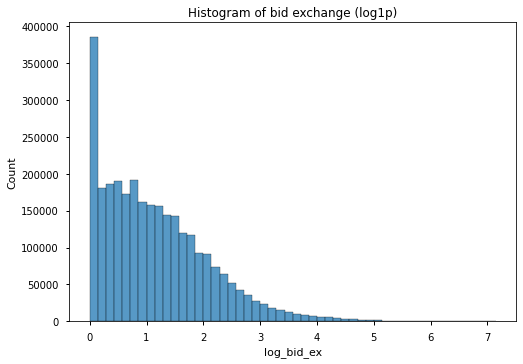

In [96]:
data["log_bid_ex"] = np.log1p(data["bid_ex"])
ax = sns.histplot(data, x="log_bid_ex", bins=50)  # type: ignore
ax.title.set_text("Histogram of bid exchange (log1p)")


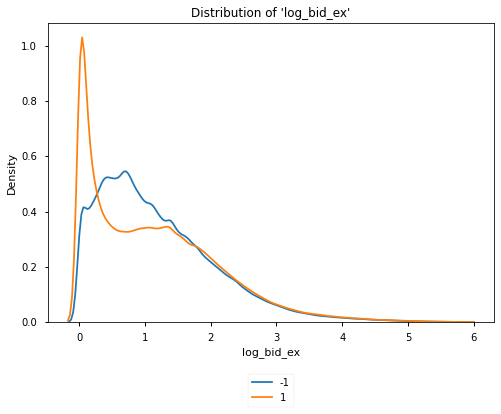

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.0339
Median value of sells =  1.0116
Median value of buys =  0.9746


In [97]:
plot_kde_target("log_bid_ex", clip=[-5, 6])


**Observation:**
- One can choose different constants, but small constants, e. g., `const=1e-2` gives fuzzy, yet distributions that are easier to distinguish. Also note the higher correlation with the target. 


**Observation:**
- log on size seems to worsen results.
- `TODO:` investigate further, what the reason is. e. g., how many outliers...

# NaNs 🪲

In [98]:
def visualize_nan():
    """
    Visualize NaN values in a heatmap to learn about patterns.
    """
    plt.subplots()
    sns.heatmap(data.head(50).isnull(), cbar=False)
    plt.xlabel("feature")
    plt.ylabel("row")
    plt.title("Missing values (colored in bright beige)")
    plt.show()


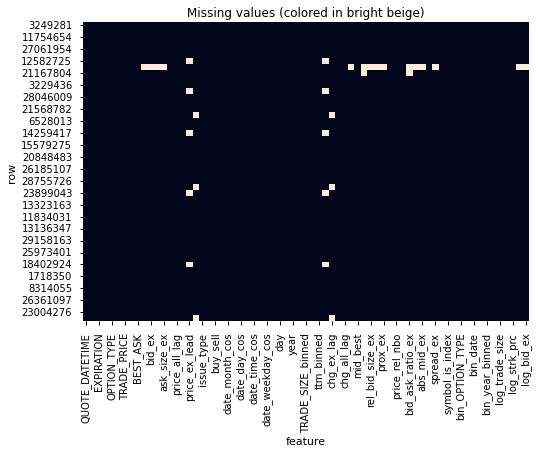

In [99]:
visualize_nan()


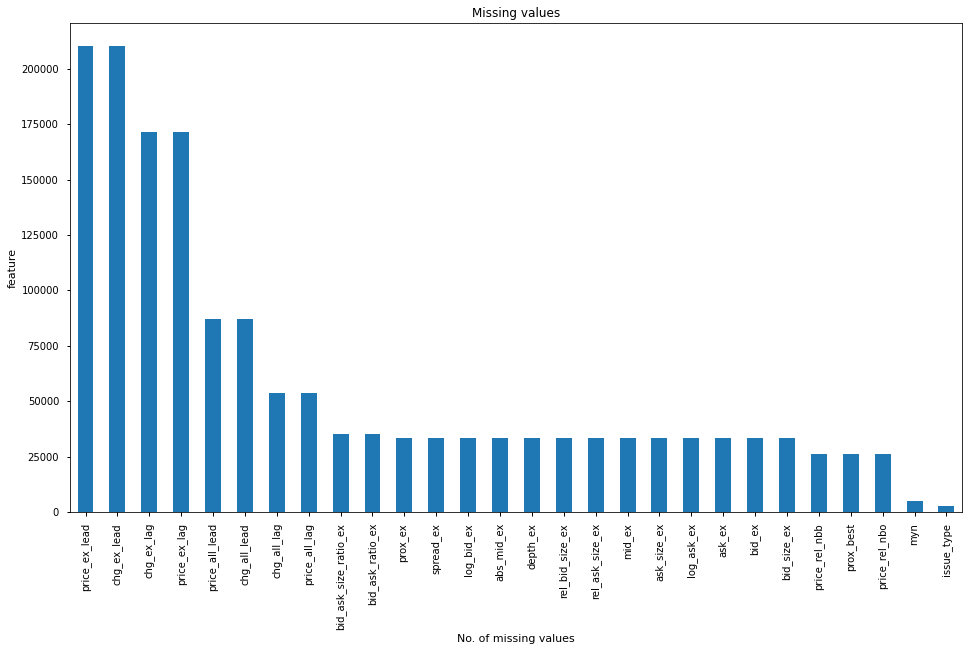

In [100]:
isna_vals = data.isna().sum().sort_values(ascending=False)
isna_vals = isna_vals.loc[lambda x: x > 0]

ax = isna_vals.T.plot(
    kind="bar",
    figsize=ratio,
    legend=False,
    xlabel="No. of missing values",
    ylabel="feature",
    title="Missing values",
)


<AxesSubplot:title={'center':'Missing values over time'}, xlabel='Timestamp', ylabel='No. of missing values'>

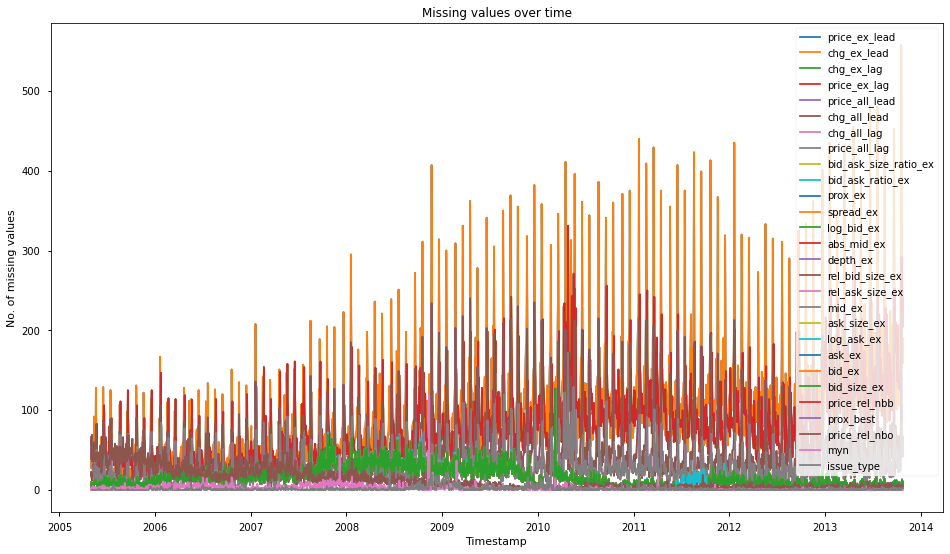

In [101]:
isna_vals_over_time = (
    data[isna_vals.index.tolist()]
    .groupby(data["QUOTE_DATETIME"].dt.date)
    .agg(lambda x: x.isnull().sum())
)
isna_vals_over_time.plot(
    kind="line",
    figsize=ratio,
    title="Missing values over time",
    xlabel="Timestamp",
    ylabel="No. of missing values",
)


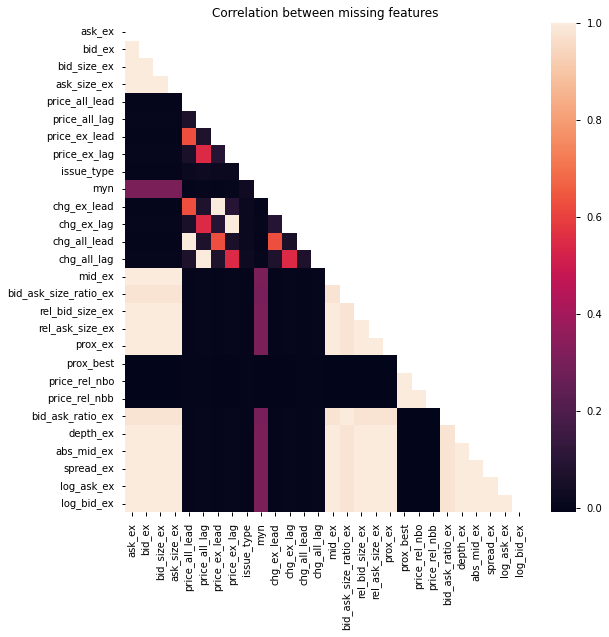

In [102]:
# adapted from: https://github.com/ResidentMario/missingno/blob/master/missingno/missingno.py

isna_data = data.iloc[
    :, [i for i, n in enumerate(np.var(data.isnull(), axis="rows")) if n > 0]
]

corr_mat = isna_data.isnull().corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(corr_mat, mask=mask, annot=False, annot_kws={"size": 10}, ax=ax)
ax.title.set_text("Correlation between missing features")


<AxesSubplot:title={'center':'Dendrogram of missing values'}>

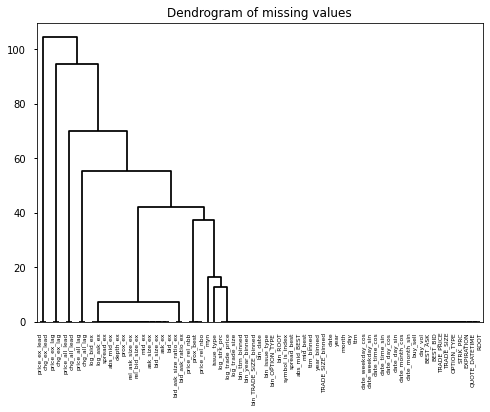

In [103]:
# adapted from: https://github.com/ResidentMario/missingno/blob/master/missingno/missingno.py

# sample down for performance reasons
isna_data = data.sample(frac=0.05)

plt.figure()
ax0 = plt.gca()

# Link the hierarchical output matrix, figure out orientation, construct base dendrogram.
x = np.transpose(isna_data.isnull().astype(int).values)
z = hierarchy.linkage(x, "average")

hierarchy.dendrogram(
    z,
    labels=isna_data.columns.tolist(),
    distance_sort=False,
    link_color_func=lambda c: "black",
    ax=ax0,
)

# Remove extraneous default visual elements.
ax0.set_aspect("auto")
ax0.set_title("Dendrogram of missing values")

ax0


**Observation:**
- Note that also important features like `price_all_lead` or `price_ex_lag` are missing. This has an impact, whether it is possible to calculate the classical rules like the trade rule. Consider this when reporting results.
- Missing values become more of a problem towards the end of the data set. At the same time the number of trades also increases.

# Correlations of engineered features 🎲

### Correlations 🎲

<AxesSubplot:>

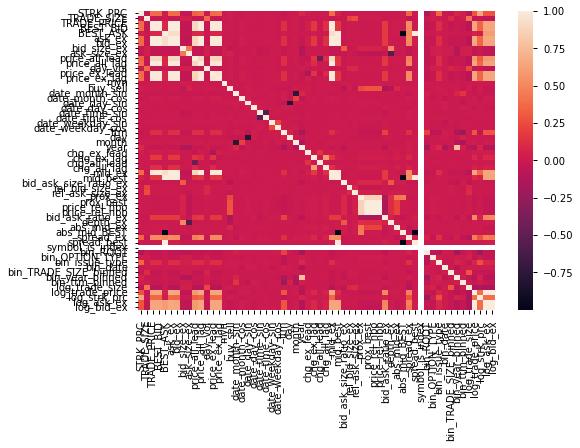

In [104]:
corr = data.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)  # type: ignore


### Correlation with target 🎲

In [105]:
sort_criteria = corr["buy_sell"].abs().sort_values(ascending=False)
corr_target = corr.sort_values("buy_sell", ascending=False)["buy_sell"]
corr_target.loc[sort_criteria.index].to_frame()


,buy_sell
buy_sell,1.000000
price_rel_nbo,0.285073
prox_best,0.285073
price_rel_nbb,0.285073
prox_ex,0.235650
bid_ask_ratio_ex,-0.156145
depth_ex,-0.088531
abs_mid_ex,0.082089
bid_ask_size_ratio_ex,-0.067924
ask_size_ex,0.047890


In [106]:
# adapted from here: https://www.kaggle.com/code/willkoehrsen/featuretools-for-good

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.975)]

print(to_drop)


['BEST_BID', 'ask_ex', 'bid_ex', 'price_all_lag', 'price_ex_lead', 'price_ex_lag', 'mid_ex', 'mid_best', 'price_rel_nbo', 'price_rel_nbb', 'abs_mid_BEST', 'spread_best', 'log_ask_ex', 'log_bid_ex']


**Observation:**
- Newly engineered features have a high correlation with the target, which is positive. Investigate if the correlation is due to randomness or whether a pattern is observable.
- `_ex` and `BEST_` features seem to be rather redundant, even if a high threshold for correlation is chosen.

### Collinearity of features🎲

In [107]:
# Set the threshold
threshold = 0.975

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corr:
    above_threshold_vars[col] = list(corr.index[corr[col] > threshold])

pd.Series(above_threshold_vars)


STRK_PRC                                                        [STRK_PRC]
TRADE_SIZE                                                    [TRADE_SIZE]
TRADE_PRICE              [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_BID                 [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_ASK                                 [BEST_ASK, mid_best, spread_best]
ask_ex                   [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_ex                   [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_size_ex                                                  [bid_size_ex]
ask_size_ex                                                  [ask_size_ex]
price_all_lead                                            [price_all_lead]
price_all_lag            [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
day_vol                                                          [day_vol]
price_ex_lead            [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
price_ex_lag             

# Analyses of engineered features

In [108]:
corr_target.loc[sort_criteria.index].to_frame().T


,buy_sell,price_rel_nbo,prox_best,price_rel_nbb,prox_ex,bid_ask_ratio_ex,depth_ex,abs_mid_ex,bid_ask_size_ratio_ex,ask_size_ex,...,year,abs_mid_BEST,spread_best,bin_year_binned,date_time_sin,BEST_ASK,bin_OPTION_TYPE,mid_best,myn,symbol_is_index
buy_sell,1.0,0.285073,0.285073,0.285073,0.23565,-0.156145,-0.088531,0.082089,-0.067924,0.04789,...,0.001401,0.001181,-0.000892,0.000822,0.000676,-0.000599,0.000574,-0.000306,0.000163,NaN


### What works ✔️

#### Trade price vs distance from mid

Similar to `EMO`, where the applied rule depends on whether the trade is at the ask or bid. Similarily `CLVN` uses percentage bounds e. g., $~20~\%$ of spread.

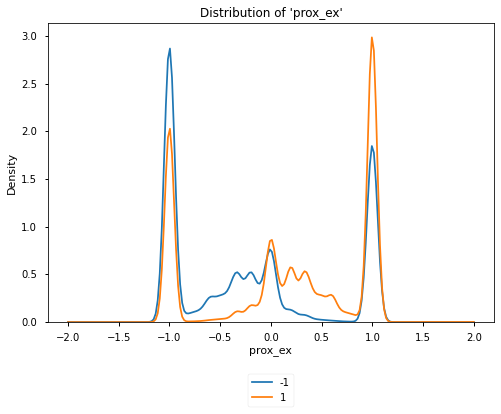

The correlation between 'prox_ex' and the 'buy_sell' is  nan
Median value of sells = -0.3333
Median value of buys =  0.3200


In [109]:
plot_kde_target("prox_ex", clip=[-2, 2])


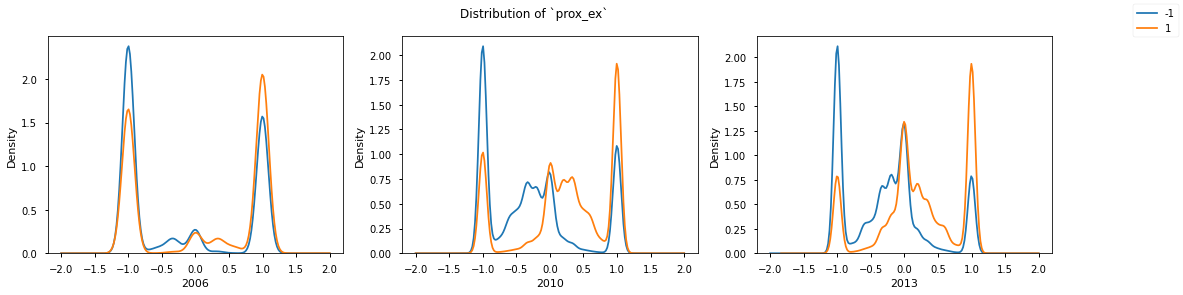

In [110]:
plot_kde_target_comparsion("prox_ex", years=[2006, 2010, 2013], clip=[-2, 2])


#### Depth

Implicitly used in depth rule. Depth rule would assign a buy if `bid_ask_size_ratio_ex` is above one and a sell if it is below zero. But only used for mid-spread trades.

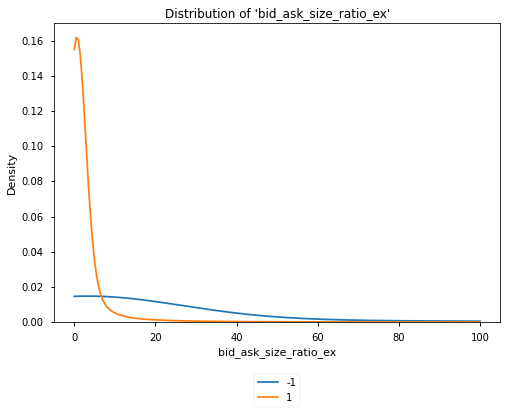

The correlation between 'bid_ask_size_ratio_ex' and the 'buy_sell' is  nan
Median value of sells =  1.3810
Median value of buys =  0.5780


In [111]:
plot_kde_target("bid_ask_size_ratio_ex", clip=[0, 100])


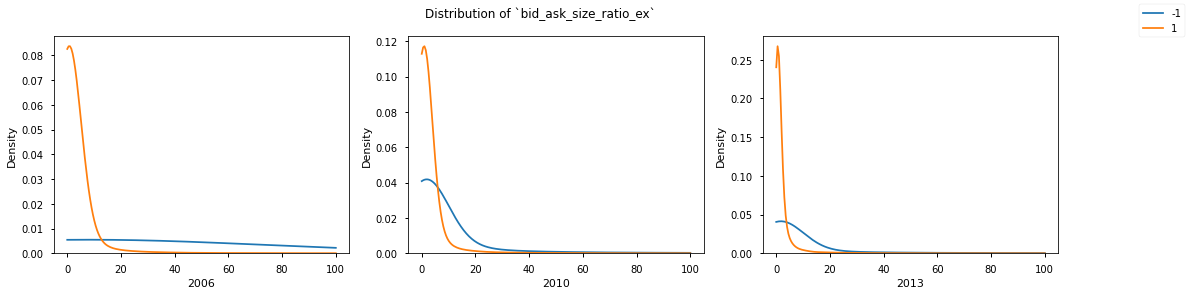

In [112]:
plot_kde_target_comparsion(
    "bid_ask_size_ratio_ex", years=[2006, 2010, 2013], clip=[0, 100]
)


#### $\log$ bid ex

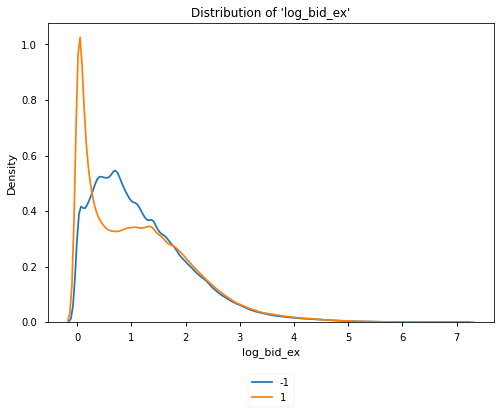

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.0339
Median value of sells =  1.0116
Median value of buys =  0.9746


In [113]:
plot_kde_target("log_bid_ex")


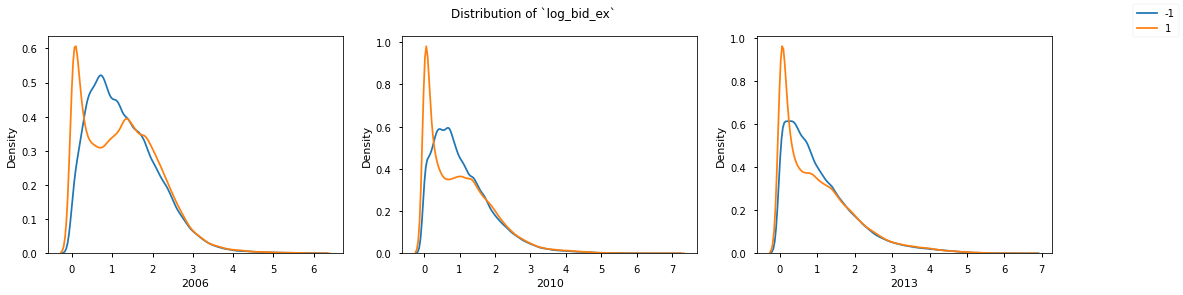

In [114]:
plot_kde_target_comparsion("log_bid_ex", years=[2006, 2010, 2013])


**Observation:**
- Application of the $\log$ leads to highly differentiable distributions, that remain stable over time.

#### $\log$ trade price

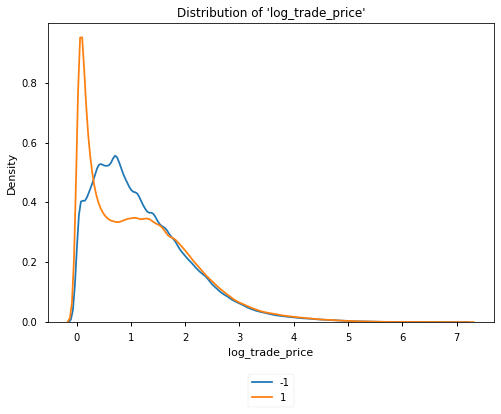

The correlation between 'log_trade_price' and the 'buy_sell' is -0.0266
Median value of sells =  1.0260
Median value of buys =  1.0006


In [115]:
plot_kde_target("log_trade_price")


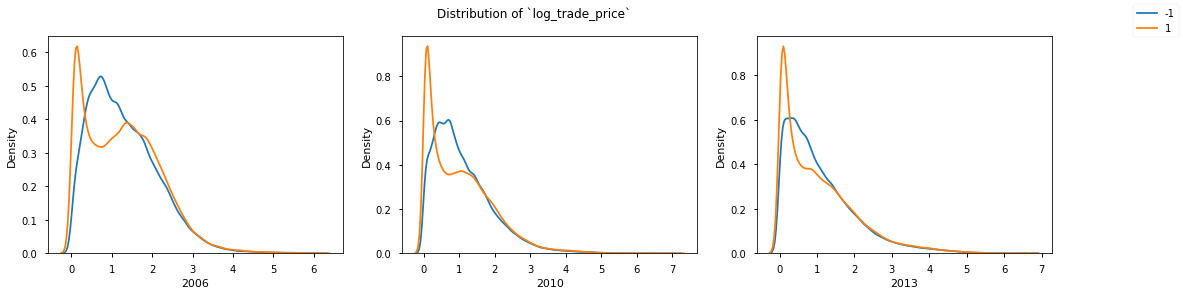

In [116]:
plot_kde_target_comparsion("log_trade_price", years=[2006, 2010, 2013])


**Observation:**
- Application of the $\log$ leads to highly differentiable distributions, that remain stable over time.

#### Ask size

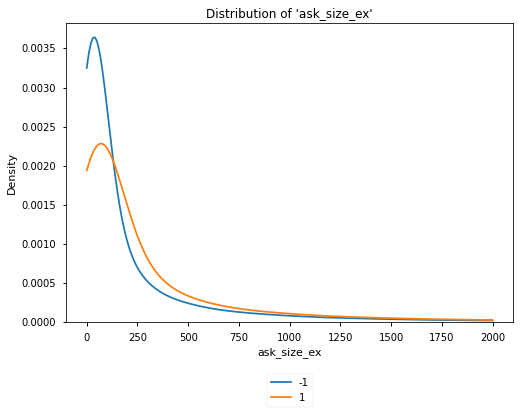

The correlation between 'ask_size_ex' and the 'buy_sell' is  0.0479
Median value of sells =  59.0000
Median value of buys =  102.0000


In [117]:
plot_kde_target("ask_size_ex", clip=[0, 2000])


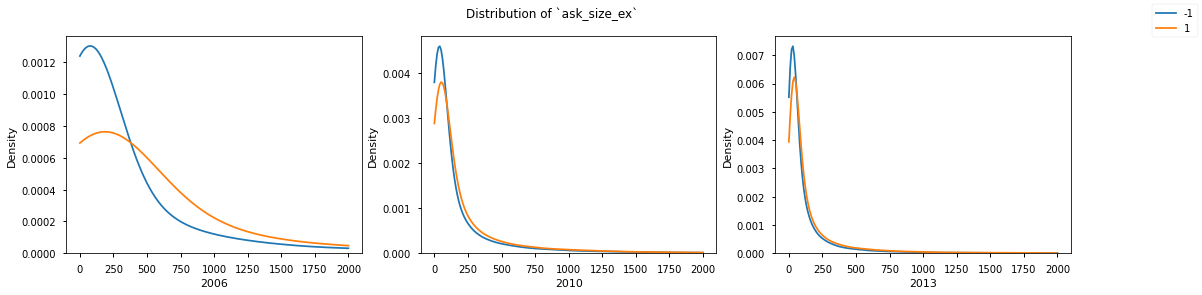

In [118]:
plot_kde_target_comparsion("ask_size_ex", years=[2006, 2010, 2013], clip=[0, 2000])


#### Bid size

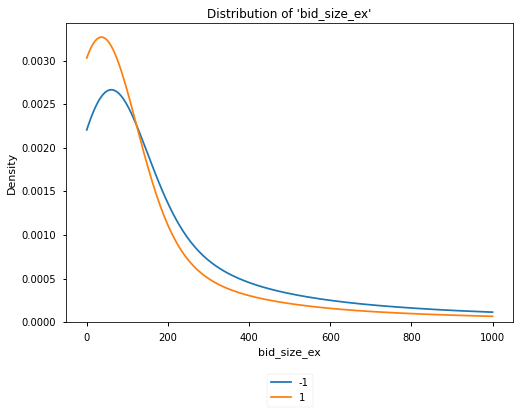

The correlation between 'bid_size_ex' and the 'buy_sell' is -0.0466
Median value of sells =  103.0000
Median value of buys =  47.0000


In [119]:
plot_kde_target("bid_size_ex", clip=[0, 1000])


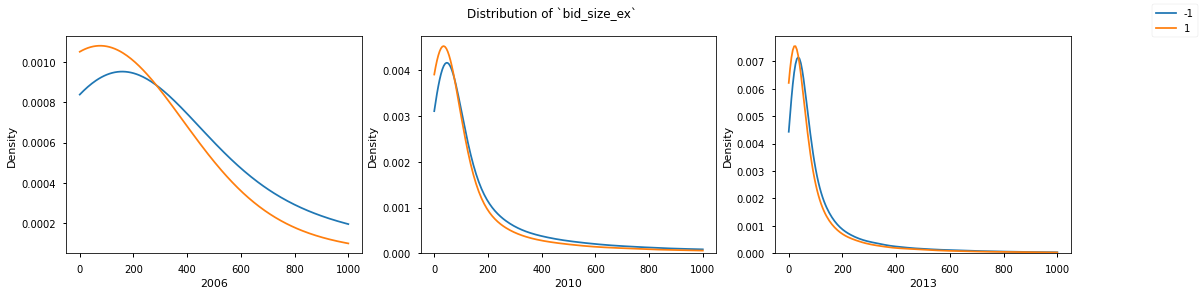

In [120]:
plot_kde_target_comparsion("bid_size_ex", years=[2006, 2010, 2013], clip=[0, 1000])


#### Quote rule

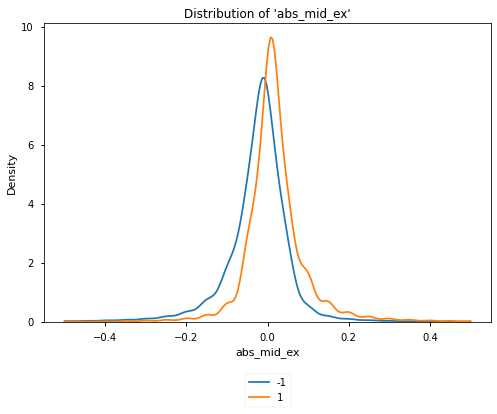

The correlation between 'abs_mid_ex' and the 'buy_sell' is  0.0821
Median value of sells = -0.0150
Median value of buys =  0.0100


In [121]:
plot_kde_target("abs_mid_ex", clip=[-0.5, 0.5])


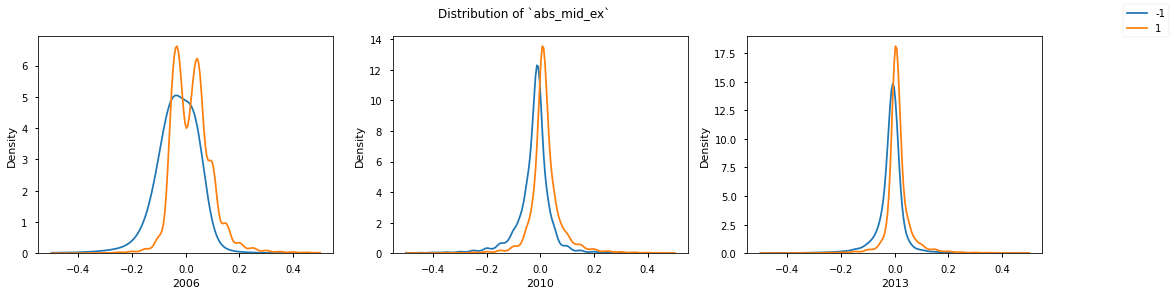

In [122]:
plot_kde_target_comparsion("abs_mid_ex", years=[2006, 2010, 2013], clip=[-0.5, 0.5])


**Observation:**
- Compared with tick rule or reverse tick rule, quote rule is the only classical rule, where distributions are somewhat distinguishable
- On can clearly see that the quote rule works better at the beginning of the data set and its performance worsens over time.

#### Day of the month

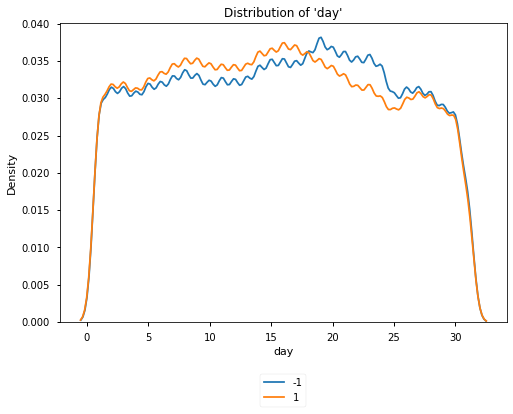

The correlation between 'day' and the 'buy_sell' is -0.0182
Median value of sells =  16.0000
Median value of buys =  15.0000


In [123]:
plot_kde_target("day")


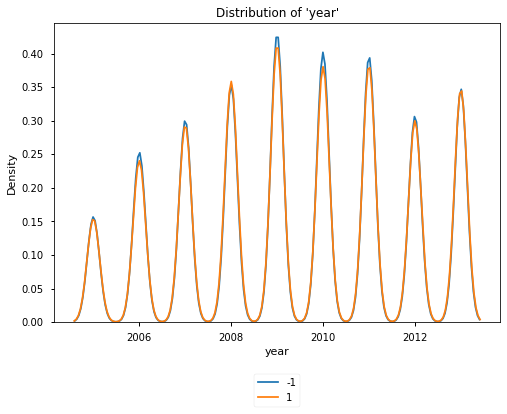

The correlation between 'year' and the 'buy_sell' is  0.0014
Median value of sells =  2009.0000
Median value of buys =  2009.0000


In [124]:
plot_kde_target("year")


**Observation:**
* Judging from the plot there seems to be a seasonal pattern e. g., more buys 
at the beginning of the month and more sells towards the end of the month. 
* Due to the distributions it could make sense to include date features in some feature sets. But do not include in the most basic data set.

## What doesn't ❌

#### tick rule

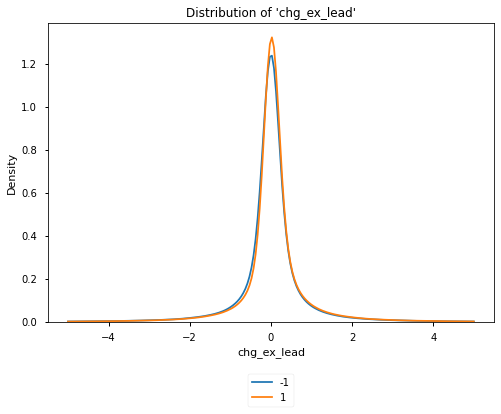

The correlation between 'chg_ex_lead' and the 'buy_sell' is  0.0112
Median value of sells =  0.0100
Median value of buys =  0.0200


In [125]:
plot_kde_target("chg_ex_lead", clip=[-5, 5])


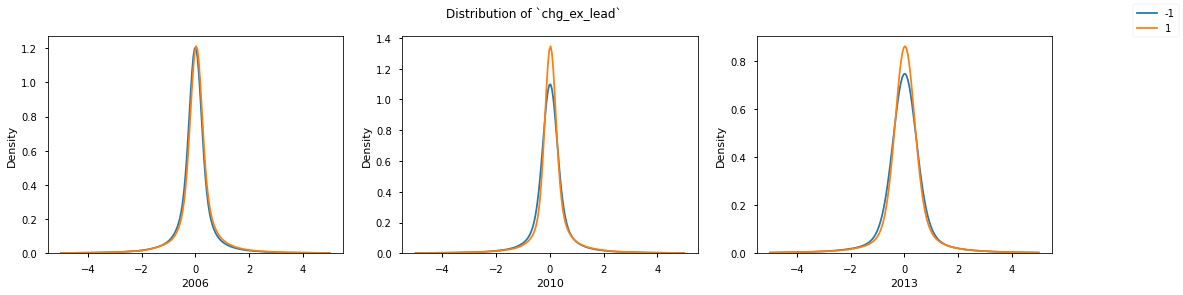

In [126]:
plot_kde_target_comparsion("chg_ex_lead", years=[2006, 2010, 2013], clip=[-5, 5])


**Observation:**
- Distributions are hardly distinguishable. 
- Results seem to worsen over time, which is consistent to the observations of Grauer et. al.

#### reverse tick rule

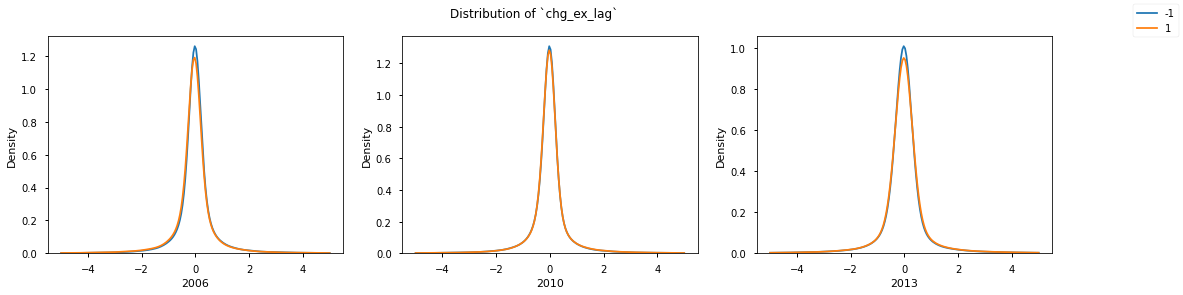

In [127]:
plot_kde_target_comparsion("chg_ex_lag", years=[2006, 2010, 2013], clip=[-5, 5])


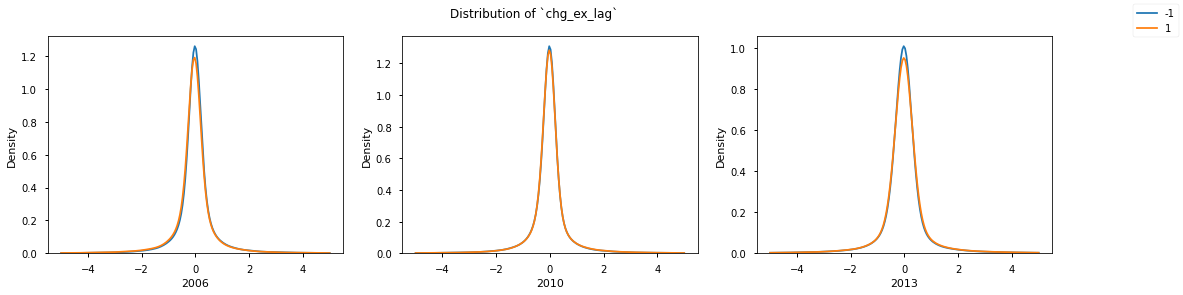

In [128]:
plot_kde_target_comparsion("chg_ex_lag", years=[2006, 2010, 2013], clip=[-5, 5])


**Observation:**
- Distributions are hardly distinguishable. 
- Results worsen over time.

# Impact of scaling 🔢

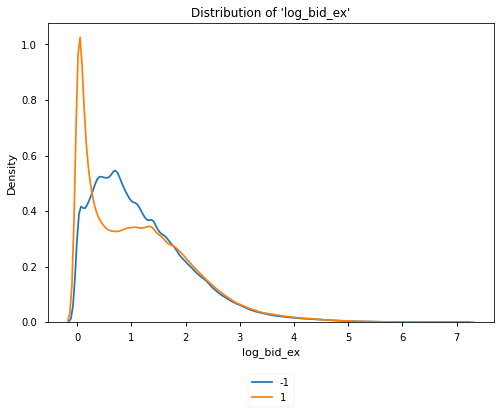

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.0339
Median value of sells =  1.0116
Median value of buys =  0.9746


In [129]:
plot_kde_target("log_bid_ex", clip=[-5, 8])


In [130]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)


In [133]:
scaler = StandardScaler()
data["log_bid_ex_scaled"] = scaler.fit_transform(
    X=data["log_bid_ex"].values.reshape(-1, 1)
)


In [134]:
data["log_bid_ex_scaled"].describe()


count    2.913070e+06
mean     7.678973e-09
std      1.000000e+00
min     -1.242373e+00
25%     -8.083098e-01
50%     -1.790652e-01
75%      5.826147e-01
max      6.404423e+00
Name: log_bid_ex_scaled, dtype: float64

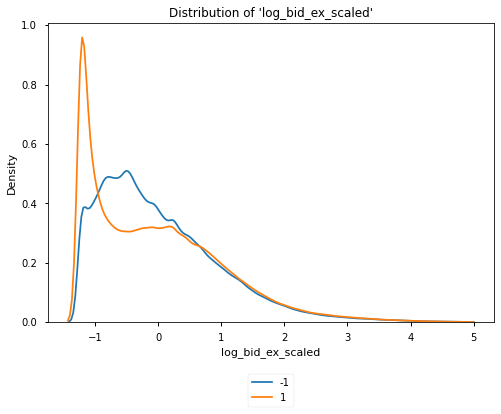

The correlation between 'log_bid_ex_scaled' and the 'buy_sell' is -0.0339
Median value of sells = -0.1594
Median value of buys = -0.1991


In [135]:
plot_kde_target("log_bid_ex_scaled", clip=[-5, 5])


Results as expected. Scaling using `StandardScaler` does not affect distribution of data.

# Conclusion 🔗

**Observation:**
* $log$ transform makes no difference for gbms as shown in `3.0b-mb-comparsion-transformations.ipynb`. This is consistent with literature, as trees don't consider distributions. $log$
* Imputation makes hardly any differnce for gbms as shown in `3.0b-mb-comparsion-transformations.ipynb`. Passing missing values to the model yields slightly better results. This is also expected.
* Incorporating highly correlated columns is no problem for gbms and neural nets from a theoretical standpoint.
- Features of Grauer et. al seem to work. 
- Binning gives mixed results e. g., for trade size and ttm.
- Theoretically, highly correlated columns don't matter for gradient boosting and neural networks.
